# Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from stats import  full_bootstrap_mean_diff, standardize_data, bootstrap_expected_mean_difference
from stats import *

In [67]:
from statsmodels.stats import multitest

In [2]:
import warnings
warnings.filterwarnings("ignore")

# strategies

Перед тем, как сравнивать частоту употребления стратегий в группах, стоит убедиться, что нету для каждой из стратегий зависимости между тем, сколько человек сказал слов


In [74]:
strats_ = pd.read_csv('strategies_fractions.tsv', sep='\t')
strats_.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type
0,pr_A_1,0.227273,0.113636,0.295455,0.363636,senior academics
1,pr_B_1,0.196078,0.058824,0.313725,0.431373,senior academics
2,pr_E_1,0.096154,0.019231,0.192308,0.692308,senior academics
3,pr_G_1,0.254545,0.018182,0.127273,0.600000,senior academics


In [75]:
strats = pd.read_csv('strategies_counts.tsv', sep='\t')
strats.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics
1,pr_B_1,10.0,3.0,16.0,22,51.0,senior academics
2,pr_E_1,5.0,1.0,10.0,36,52.0,senior academics
3,pr_G_1,14.0,1.0,7.0,33,55.0,senior academics


<Axes: xlabel='strat_sum', ylabel='phonetic strategy'>

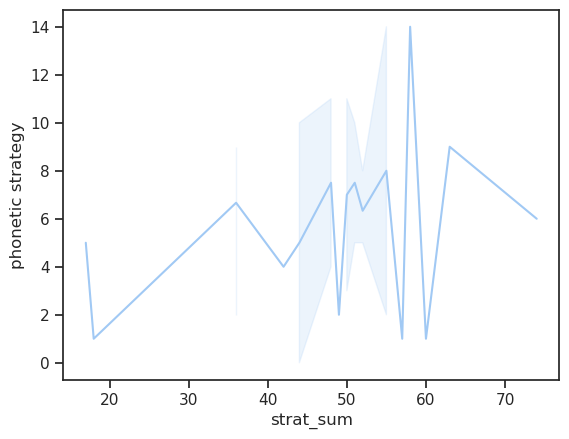

In [42]:
sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='phonetic strategy')

<Axes: xlabel='phonetic strategy', ylabel='Count'>

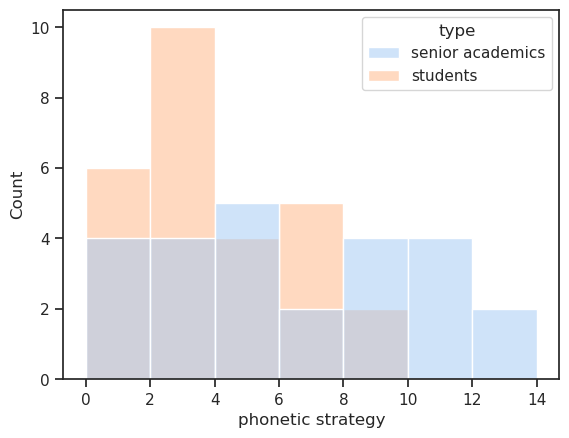

In [43]:
# sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='fonetics');
sns.histplot(strats, x='phonetic strategy',hue='type')

## количество сказанных слов

In [44]:
res = stats.normaltest(strats[strats['type']!='senior academics']['strat_sum'])
res

NormaltestResult(statistic=9.419724139375617, pvalue=0.009006019699880572)

Наблюдаемая разница средних (стандартизированная): -0.33461976839439533
p-значение: 0.522
Доверительный интервал (95%): [-0.90067817  0.20425078]


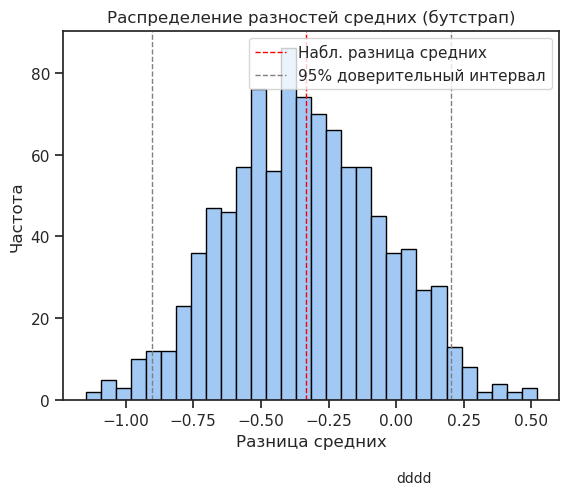

Разница средних при t-тесте (стандартизированная): -0.33461976839439533
p-значение при t-тесте: 0.23155025194351794


In [45]:
# 1. Стандартизация данных
def standardize_data(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df[column + '_standardized'] = (df[column] - mean) / std
    return df

strats = standardize_data(strats, 'strat_sum')


# 2. Бутстрап для сравнения стандартизированных средних
def bootstrap_mean_difference(group1, group2, num_iterations=1000):
    mean_diffs = []
    n1 = len(group1)
    n2 = len(group2)

    for _ in range(num_iterations):
        # Сэмплирование с возвращением
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        mean_diffs.append(mean_diff)

    return np.array(mean_diffs)

# Выбираем стандартизированные данные
group1 = strats[strats['type'] != 'senior academics']['strat_sum_standardized'].values
group2 = strats[strats['type'] == 'senior academics']['strat_sum_standardized'].values


mean_diffs_bootstrap = bootstrap_mean_difference(group1, group2)

# Вычисляем p-value и доверительный интервал
observed_diff = np.mean(group1) - np.mean(group2)
p_value = np.mean(np.abs(mean_diffs_bootstrap) >= np.abs(observed_diff))
ci = np.percentile(mean_diffs_bootstrap, [2.5, 97.5])


# Вывод результатов
print("Наблюдаемая разница средних (стандартизированная):", observed_diff)
print("p-значение:", p_value)
print("Доверительный интервал (95%):", ci)

# Строим гистограмму распределения разностей средних
plt.hist(mean_diffs_bootstrap, bins=30, edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=1, label=f'Набл. разница средних')
plt.axvline(ci[0], color='grey', linestyle='dashed', linewidth=1, label=f'95% доверительный интервал')
plt.axvline(ci[1], color='grey', linestyle='dashed', linewidth=1)
plt.title('Распределение разностей средних (бутстрап)')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.text(0, -20, 'dddd', fontsize=10)
plt.legend()
plt.show()


# Сравнение с t-тестом (для сравнения) - выводим только p-value и разницу средних
t_stat, p_value_ttest = stats.ttest_ind(group1, group2)
print("Разница средних при t-тесте (стандартизированная):", np.mean(group1) - np.mean(group2))
print("p-значение при t-тесте:", p_value_ttest)


между группами академиков и студентов принята гипотеза об отсутствии разницы между средними количества сказанных слов

In [46]:
stats.ttest_ind(strats[strats['type']!='senior academics']['strat_sum'], strats[strats['type']=='senior academics']['strat_sum'])

TtestResult(statistic=-1.2111004152791622, pvalue=0.23155025194351778, df=50.0)

## доказать независимость частот с определенной стратегией от количества сказанных слов

### доказать независимость частот со стратегией "фонетика" от количества сказанных слов

In [47]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.pearsonr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.pearsonr(x, y)
print(res_exact.pvalue, res_asymptotic.pvalue) # asymptotic pvalue is too low
print(res_exact)

0.9958 0.9871247655788858
PermutationTestResult(statistic=0.002293610595479009, pvalue=0.9958, null_distribution=array([ 0.07155107, -0.0583658 , -0.12828325, ..., -0.06089014,
       -0.18877559,  0.00522393]))


In [48]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.spearmanr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.spearmanr(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.241, 0.2388697933525074)

In [49]:
res_exact

PermutationTestResult(statistic=0.1662353346648563, pvalue=0.241, null_distribution=array([-0.08825235, -0.07524449, -0.27175305, ..., -0.07049491,
        0.02342699, -0.09178244]))

In [50]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.kendalltau(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.kendalltau(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.2662, 0.26786173211226616)

In [51]:
res_exact

PermutationTestResult(statistic=0.10811355574641349, pvalue=0.2662, null_distribution=array([ 0.02934511, -0.11043027, -0.08726308, ..., -0.0973022 ,
       -0.00231672, -0.05096782]))

не отвергаем нулевую гипотезу, частота сказанных слов со стратегией фонетика не коррелирует со общим количеством сказанных слов

Более того, в этой связи есть линейность?

(0.0, 15.0)

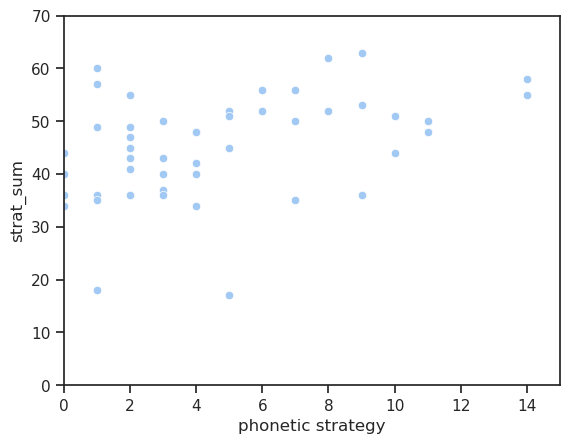

In [52]:
sns.scatterplot(strats, y='strat_sum', x='phonetic strategy');
plt.ylim(0,70)
plt.xlim(0,15)

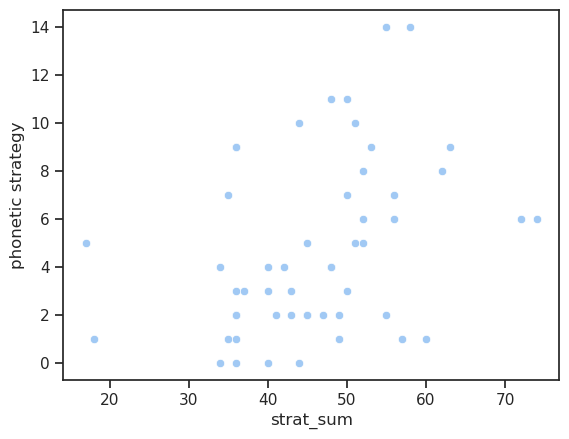

In [53]:
sns.scatterplot(strats, y='phonetic strategy', x='strat_sum');
# plt.ylim(0,70)
# plt.xlim(0,15)

поэтому не стоит сравнивать количества сказанных слов со стратегией фонетика напрямую, их надо нормализовывать по количеству сказанных слов

или стоит?? стоит, потому что на графике не видно связи, точки разбросаны

### доказать независимость частот со стратегией "лексика" от количества сказанных слов

In [54]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

## сравнение количества слов по стратегиям между группами

In [55]:
strats.head(1)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type,strat_sum_standardized
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics,-0.180984


In [56]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

In [57]:
# full_bootstrap_mean_diff(strats, 'strat_sum')
full_bootstrap_analysis(strats, 'strat_sum')

Статистика Хи-квадрат: 1.0642870890770864e-27
P-значение: 1.0
Observed difference (standardized): -0.33461976839439533
CI for observed difference [-2.3247844257211616, 1.6555448889323707]
Cohen's d (effect size): -0.3295479816901048
Expected mean diffs are normal distributed
T-student p_value: 0.2349
Нормальность средних разниц: p=0.1697
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.2218
П-значение для разницы дисперсий: 0.2142
Доверительный интервал для средней разницы H0: (-0.5428, 0.5385)
Эффект (Cohen's D): -0.3295


(array([ 0.05255246,  0.25914263, -0.01729405, ..., -0.1280296 ,
         0.16596926,  0.12601866]),
 True,
 (-0.5428220383506075, 0.5385320413199101),
 -0.33461976839439533,
 -0.3295479816901048,
 0.2218,
 -1.1978617840547632,
 0.2348765123487651)

принимаем нулевую гипотезу об отсутствии различий в среднем количестве сказанных слов

In [58]:
strategies_list = ['phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy']

In [60]:
# pval = []
# es = []
# for i in strategies_list:
#     print (i)
#     mean_diffs, var_diffs, t_stats, p_value_mean, p_value_var, ci_mean, cohens_d = full_bootstrap_analysis(strats, i)
#     # ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
#     pval.append(p_value_mean)
#     es.append(cohens_d)
#     print('______________')
    

In [20]:
strategies_list
#ofld

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [21]:
pval

[0.0095, 0.911, 0.0022, 0.0843]

In [22]:
es

[-0.7398906246454715,
 -0.030915484095687527,
 -0.9162600429636434,
 0.47685591304288694]

In [40]:
# plt.text(2.7, 257.5, f"ES = {es[3]:.1f}", rotation = 0, fontsize = 11
#          )       

# plt.text(2.7, 240, f"p value = {pval[3]:.3f}", rotation = 0, fontsize = 11 
#          )      

In [41]:
int(3/2)

1

In [14]:
# sns.set_theme(style="ticks", palette="pastel");
# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 12), dpi=300)
# j=0
# for i in strategies_list:
    

#     ax = sns.boxplot(strats, y=i, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
#                      ,ax=axs[j%2][int(j/2)]
#                      );
    
#     ax.set_xlabel(f'Strategy "{i}"')

#     ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
#     ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)

#     # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
#     # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
#     j+=1


# # plt.xlabel('group')
# # plt.title(f'Strategies between groups')
# fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
# plt.tight_layout()
# plt.show();

## сравнение фракций для каждой стратегии между группами

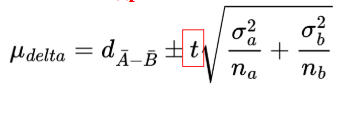

In [76]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [77]:
strategies_dict = {'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy' : 'S3',
 'individual association strategy' : 'S4'}

# S1. Phonetic strategy

# S2. Derivative strategy

# S3. Semantic-field strategy

# S4. Individual association strategy

In [96]:
paper_table = pd.DataFrame(columns=['Variable', 'Normal sampling distribution', 'H0 CI', 'Delta observed' ,'Cohens delta'
                                    , 'Bootstrap p value'
                                    , 'Bootstrap p value corrected'
                                    , 'Stat metric value'
                                    , 'Stat p value'
                                    , 'Stat p value corrected'
                                    ])
paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Bootstrap p value,Bootstrap p value corrected,Stat metric value,Stat p value,Stat p value corrected


phonetic strategy
Статистика Хи-квадрат: 3.7455510799145956e-27
P-значение: 1.0
Observed difference (standardized): -0.7322845788979099
CI for observed difference [-2.6089392558391884, 1.1443700980433689]
Cohen's d (effect size): -0.7648065423412013
Expected mean diffs are normal distributed
T-student p_value: 0.0080
Нормальность средних разниц: p=0.8564
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0079
П-значение для разницы дисперсий: 0.0080
Доверительный интервал для средней разницы H0: (-0.5413, 0.5304)
Эффект (Cohen's D): -0.7648


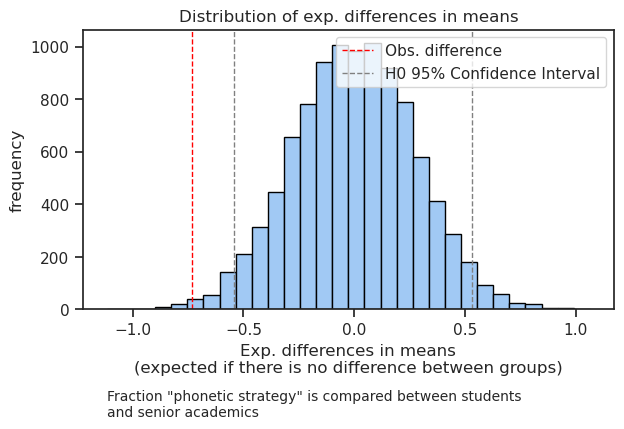

______________
derivative strategy
Статистика Хи-квадрат: 3.1906481647282456e-27
P-значение: 1.0
Observed difference (standardized): 0.15240310026279258
CI for observed difference [-1.8612174818088059, 2.166023682334391]
Cohen's d (effect size): 0.1483447672191365
Expected mean diffs are normal distributed
T-student p_value: 0.6166
Нормальность средних разниц: p=0.4512
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.5867
П-значение для разницы дисперсий: 0.1115
Доверительный интервал для средней разницы H0: (-0.5428, 0.5447)
Эффект (Cohen's D): 0.1483


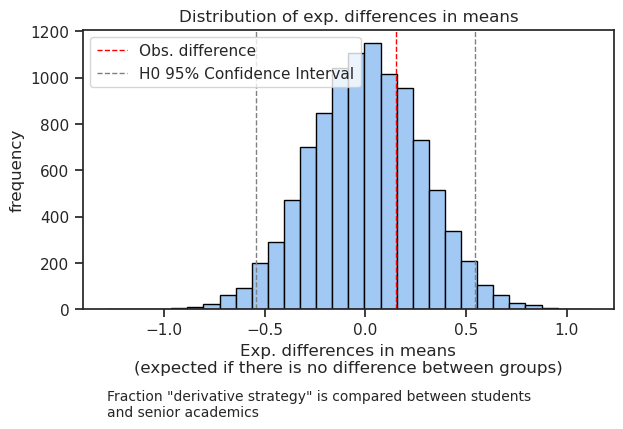

______________
semantic-field strategy
Статистика Хи-квадрат: 2.1367397940916157e-27
P-значение: 1.0
Observed difference (standardized): -0.8249796674856253
CI for observed difference [-2.6615700267401934, 1.011610691768943]
Cohen's d (effect size): -0.8804141544814131
Expected mean diffs are normal distributed
T-student p_value: 0.0035
Нормальность средних разниц: p=0.3561
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0033
П-значение для разницы дисперсий: 0.0057
Доверительный интервал для средней разницы H0: (-0.5577, 0.5433)
Эффект (Cohen's D): -0.8804


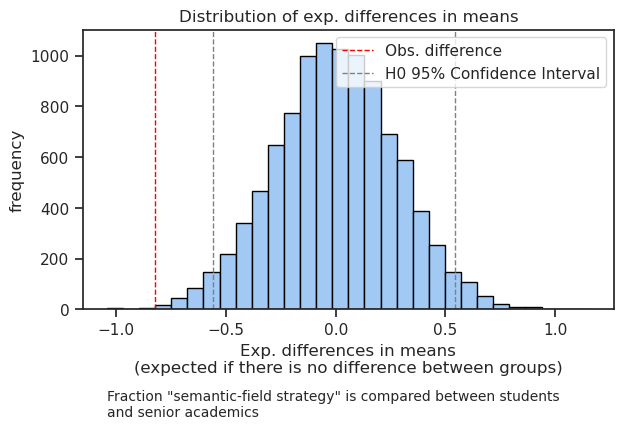

______________
individual association strategy
Статистика Хи-квадрат: 1.271169491526529e-28
P-значение: 1.0
Observed difference (standardized): 0.895257942376215
CI for observed difference [-0.9064326895829828, 2.696948574335413]
Cohen's d (effect size): 0.9739216799663748
Expected mean diffs are normal distributed
T-student p_value: 0.0008
Нормальность средних разниц: p=0.6452
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0014
П-значение для разницы дисперсий: 0.0480
Доверительный интервал для средней разницы H0: (-0.5342, 0.5233)
Эффект (Cohen's D): 0.9739


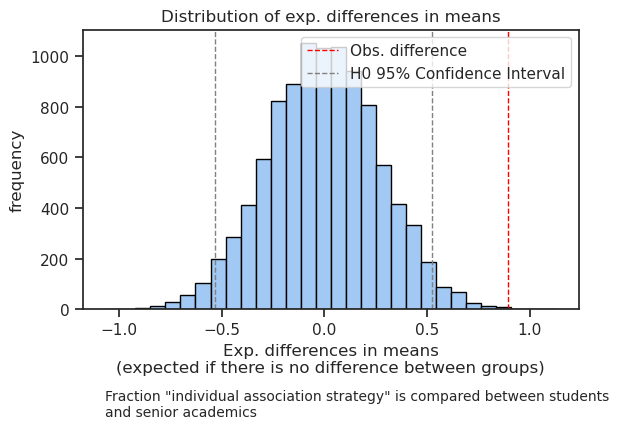

______________


In [ ]:
pval = []
# es = []
pval_st = []
normality = []
for i in strategies_list:
    print (i)
    # mean_diffs, var_diffs, t_stats, p_value_mean, p_value_var, ci_mean, cohens_d, pst = full_bootstrap_analysis(strats_, i)
    # p_value_mean, normal, pst = full_bootstrap_analysis(strats_, i)
    # ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(strats_, i)
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Fraction ")
    paper_table.loc[len(paper_table)] = [f'Fraction of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), 0, round(Crit_metric, 2), round(pst, 4), 0]
    print('______________')

# fdr correction
pval_st = multitest.fdrcorrection(pval_st)[1]
pval = multitest.fdrcorrection(pval)[1]

paper_table['Bootstrap p value corrected'] = pval
paper_table['Stat p value corrected'] = pval_st

In [92]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats_, i,num_it=10000)
#     pval.append(p_value)
#     es.append(cohens_d)

In [99]:
strategies_dict

{'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy': 'S3',
 'individual association strategy': 'S4'}

In [100]:
strats_.head()

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type,phonetic strategy_standardized,derivative strategy_standardized,semantic-field strategy_standardized,individual association strategy_standardized
0,pr_A_1,0.227273,0.113636,0.295455,0.363636,senior academics,1.596786,0.555410,1.113716,-2.032453
1,pr_B_1,0.196078,0.058824,0.313725,0.431373,senior academics,1.196611,-0.132867,1.321785,-1.515868
2,pr_E_1,0.096154,0.019231,0.192308,0.692308,senior academics,-0.085269,-0.630028,-0.060917,0.474136
3,pr_G_1,0.254545,0.018182,0.127273,0.600000,senior academics,1.946653,-0.643200,-0.801533,-0.229842
4,pr_I_1,0.083333,0.020833,0.187500,0.708333,senior academics,-0.249736,-0.609905,-0.115667,0.596355


In [101]:
strats_.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy', 'type',
       'phonetic strategy_standardized', 'derivative strategy_standardized',
       'semantic-field strategy_standardized',
       'individual association strategy_standardized'],
      dtype='object')

In [102]:
boxpl_strats = strats_[['type', 'ID',
       'phonetic strategy', 'derivative strategy',
       'semantic-field strategy',
       'individual association strategy']].melt(id_vars=['type', 'ID'], value_vars=['phonetic strategy', 'derivative strategy',
       'semantic-field strategy',
       'individual association strategy'])

In [103]:
boxpl_strats['Strategy'] = boxpl_strats['variable'].apply(lambda x: strategies_dict.get(x
                                                                                        )
                                                            )
boxpl_strats['value'] = boxpl_strats['value']*100

In [104]:
boxpl_strats.head(2)

,type,ID,variable,value,Strategy
0,senior academics,pr_A_1,phonetic strategy,22.727273,S1
1,senior academics,pr_B_1,phonetic strategy,19.607843,S1


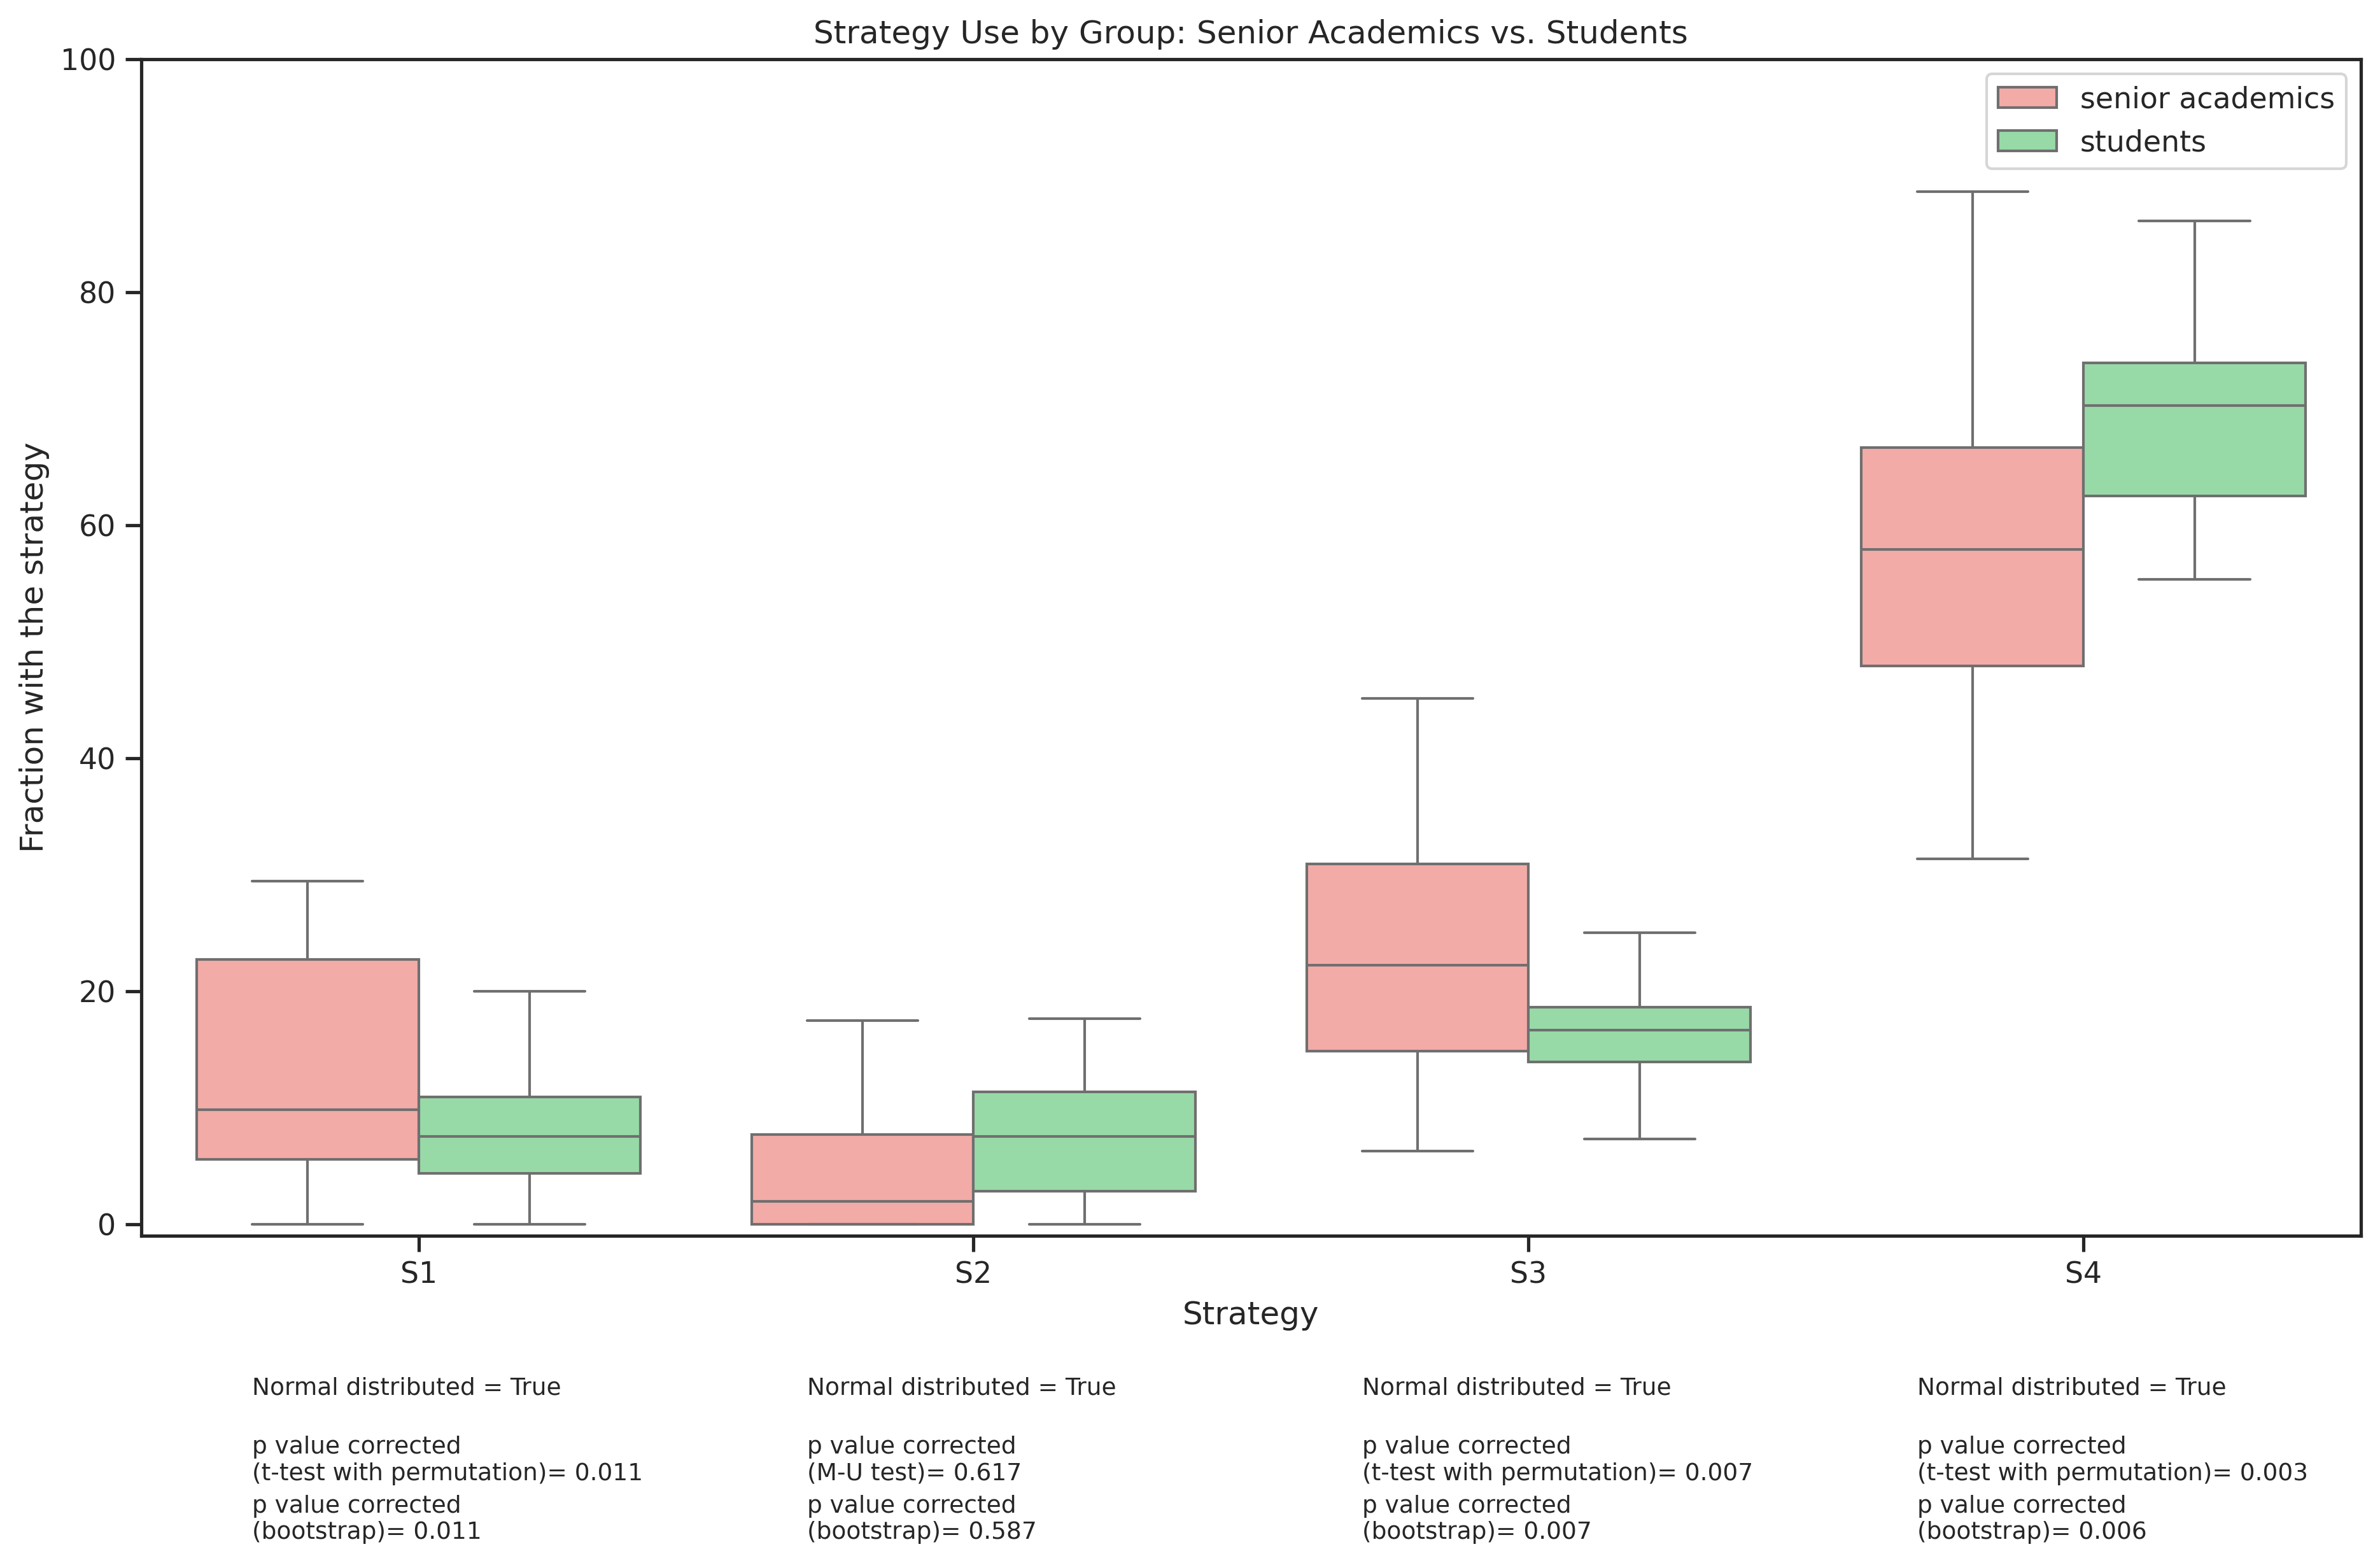

In [107]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = boxpl_strats.sort_values(['Strategy']), x='Strategy',y='value', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.xlabel('Strategy')
plt.ylabel('Fraction with the strategy')
plt.title(f'Strategy Use by Group: Senior Academics vs. Students')
plt.ylim(-1, 100)

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(normality)):
      g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      if pval_st[i]<=0.05:
            g.text(i*0.25+0.05, -0.17, f"p value corrected \n(t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      else:
            g.text(i*0.25+0.05, -0.17, f"p value corrected \n(M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value corrected \n(bootstrap)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
fig.savefig(f'figures/Strategy Use by Group: Senior Academics vs. Students.png', bbox_inches='tight')

In [116]:
# sns.set_theme(style="ticks", palette="pastel");
# fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 8), dpi=300)
# j=0
# for i in strategies_list:
    

#     ax = sns.boxplot(strats_, y=strats_[i]*100, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
#                      ,ax=axs[j]
#                      );
    
#     # ax.set_xlabel(f'Strategy "{i}"',    loc='left')
#     ax.set_title(f'Strategy "{strategies_dict.get(i)}"')
#     ax.set_xlabel('group')

#     # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
#     # ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
#     # ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
#     # ax.text(0.02, -0.2, f"T ({i}) = {T:.2f}", ha="left", va="top", transform=ax.transAxes)
#     ax.text(0.02, -0.15, f"p value (t_test with permutation)= {pval_st[j]:.3f}", ha="left", va="top", transform=ax.transAxes
#             , fontsize =9)
#     ax.text(0.02, -0.20, f"Normal distributed = {str(normality[j])}", ha="left", va="top", transform=ax.transAxes
#             , fontsize =9)
#     ax.text(0.02, -0.1, f"p value (bootstrap)= {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
#     ax.set_ylim(-1,100)
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     # ax.spines['bottom'].set_visible(False)
#     if j!=0:
#         ax.set(ylabel=None)
#         ax.tick_params(left=False)
#         ax.set(yticklabels=[])
#         ax.spines['left'].set_visible(False)
#     else:
#         ax.set(ylabel= "Fraction with the strategy")
        
#     # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
#     # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
#     j+=1


# # plt.xlabel('group')
# # plt.title(f'Strategies between groups')
# fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
# fig.text(0.06, -0.04, "Fraction = (words count with Si strategy)/(words count) * 100")
# plt.tight_layout()
# plt.show();

# Words

In [108]:
words = pd.read_csv('words.tsv', sep='\t')

df = words.fillna('0')
# df['Стратегия'] = df['Стратегия'].str[0]
# def renamestrats(row):
#     '''
#     df['phonetic strategy'] = df['1'] 
#     df['derivation'] = df['2']
#     df['lexico-semantic field'] = df['3'] + df['4'] + df['5'] + df['6'] + df['7']
#     df['other'] = df['8']

#     '''
    
    
#     stratsfict = {'1':'fonetics', '2': 'derivation', 
#                   '8':'other', **dict.fromkeys(['n', '0'], 'None')
#                   }
#     stratsfict.update(dict.fromkeys(['3', '4', '5', '6', '7'], 'lexico-semantic field'))
#     #print(stratsfict[row['Стратегия']])
#     row['strategy_name']=stratsfict[row['Стратегия']]
#     return row

# df = df.apply(renamestrats, axis=1)
df['frequency'] = df['frequency'].astype('float', errors = 'ignore')
df['pause'] = df['pause'].astype('float', errors='ignore' )
df.head()

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,0,п,0,1.0,1,152.7,...,0,0,59,28,13,18,2.390357,students,0,0
1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,204.2,...,0,0,59,28,13,18,2.390357,students,individual association strategy,S4
2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,13.2,...,1.0,0,59,28,13,18,2.390357,students,phonetic strategy,S1
3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,12.7,...,1.0,0,59,28,13,18,2.390357,students,individual association strategy,S4
4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,5786.7,...,0,0,59,28,13,18,2.390357,students,semantic-field strategy,S3


In [109]:
words.columns

Index(['Unnamed: 0', 'ID', 'quota sec', 'word', 'previous + word',
       'first_letter', 'strategy', 'order_letter', 'order_whole_test',
       'frequency', 'pause', 'VP', 'VS', 'N of words', 'N of words_P',
       'N of words_O', 'N of words_S', 'mean pause', 'type', 'strategy_name',
       'strategy_paper_name'],
      dtype='object')

In [110]:
df[df['strategy_name']=='individual association strategy'][['type','frequency']]

,type,frequency
1,students,204.2
3,students,12.7
5,students,18.5
6,students,16.3
8,students,2.1
...,...,...
2542,senior academics,0.0
2543,senior academics,3.3
2544,senior academics,2.0
2545,senior academics,5.5


In [111]:
# df['frequency'] = pd.to_numeric(df['frequency'].str.replace(',','.'))

In [112]:
cols = df.select_dtypes('number').columns  # limits to a (float), b (int) and e (timedelta)
df_sub = df.loc[:, 'frequency']


# OPTION 1: z-score filter: z-score < 3
#lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

# OPTION 2: quantile filter: discard 1% upper / lower values
#lim = np.logical_and(df_sub < df_sub.quantile(0.99, numeric_only=False),
#                     df_sub > df_sub.quantile(0.01, numeric_only=False))

# OPTION 3: iqr filter: within 2.22 IQR (equiv. to z-score < 3)
iqr = df_sub.quantile(0.75) - df_sub.quantile(0.25)
lim = np.abs((df_sub - df_sub.median()) / iqr) < 2.22


# replace outliers with nan
df.loc[:, 'frequency'] = df_sub.where(lim, np.nan)
df = df.reset_index() #важная часть кода
df["frequency"] = df["frequency"].fillna(220)
dfj = df[df['strategy_name'] !='None']

dfj['Word frequency'] = (dfj['frequency'])

In [113]:
dfj['strategy_name'].unique()

array(['0', 'individual association strategy', 'phonetic strategy',
       'semantic-field strategy', 'derivative strategy'], dtype=object)

In [114]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [115]:
# dfj['Pause duration'] = pd.to_numeric(dfj['pause'].str.replace(',','.'))
dfj['Pause duration'] = dfj['pause']

In [116]:
dfjj = dfj[dfj['strategy_name'].isin(strategies_list)]

In [117]:
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

## Pause duration

S1. Phonetic strategy

S2. Derivative strategy

S3. Semantic-field strategy

S4. Individual association strategy

In [122]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_bootstrap_mean_diff(strats, i)
#     pval.append(p_value)
#     es.append(cohens_d)
    

In [118]:
dfjj.head()

,index,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,...,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name,Word frequency,Pause duration
1,1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,...,59,28,13,18,2.390357,students,individual association strategy,S4,220.0,0.10
2,2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,...,59,28,13,18,2.390357,students,phonetic strategy,S1,13.2,3.15
3,3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,...,59,28,13,18,2.390357,students,individual association strategy,S4,12.7,1.00
4,4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,...,59,28,13,18,2.390357,students,semantic-field strategy,S3,220.0,0.70
5,5,5,Б_В_10,1,повреждение,"['по', 'повреждение']",п,8,6.0,6,...,59,28,13,18,2.390357,students,individual association strategy,S4,18.5,3.34


In [119]:
sorted(dfjj['strategy_paper_name'].unique())

['S1', 'S2', 'S3', 'S4']

In [120]:
dfj_s = dfjj[['type','Pause duration', 'strategy_paper_name']]

In [283]:
# sns.histplot(dfj_s['Pause duration'])

In [284]:
# dfj_s = dfj_s[dfj_s['Pause duration']<=]

In [123]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

In [152]:
paper_table.tail(4)['Bootstrap p value corrected']=6

In [156]:
idx = paper_table.tail(4).index

In [171]:
idx

Index([8, 9, 10, 11], dtype='int64')

In [170]:
paper_table.index[-4:]

Index([8, 9, 10, 11], dtype='int64')

In [159]:
pval

array([0.0918    , 0.0404    , 0.6797    , 0.56626667])

S1
Статистика Хи-квадрат: 2.6406793335311468e-27
P-значение: 1.0
Observed difference (standardized): -0.26070611154974427
CI for observed difference [-2.2157831692804884, 1.694370946181]
Cohen's d (effect size): -0.2613625773045474
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.0111
Нормальность средних разниц: p=0.0000
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0485
П-значение для разницы дисперсий: 0.2071
Доверительный интервал для средней разницы H0: (-0.2490, 0.2702)
Эффект (Cohen's D): -0.2614


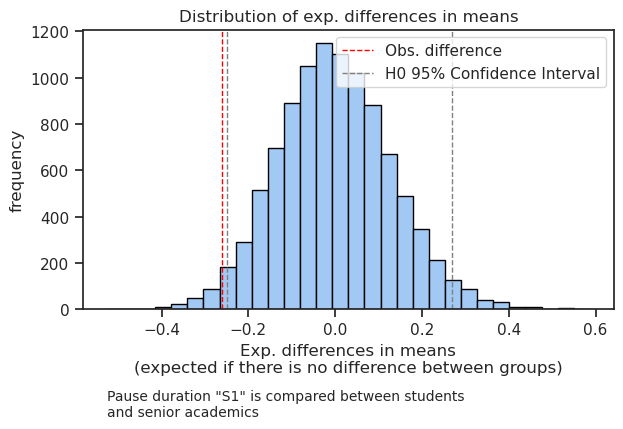

______________
S2
Статистика Хи-квадрат: 2.523544028113173e-27
P-значение: 1.0
Observed difference (standardized): 0.37826307974865436
CI for observed difference [-1.5620207685384988, 2.3185469280358078]
Cohen's d (effect size): 0.3821067917262997
Expected mean diffs are normal distributed
T-student p_value: 0.0059
Нормальность средних разниц: p=0.6266
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0104
П-значение для разницы дисперсий: 0.1028
Доверительный интервал для средней разницы H0: (-0.2871, 0.2917)
Эффект (Cohen's D): 0.3821


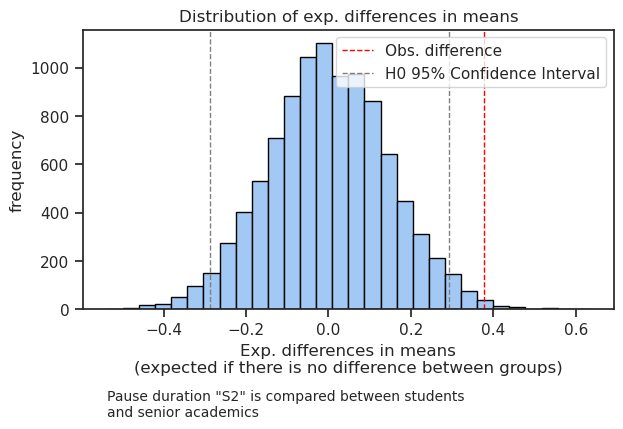

______________
S3
Статистика Хи-квадрат: 7.519766837582485e-28
P-значение: 1.0
Observed difference (standardized): -0.03845019605896864
CI for observed difference [-2.0042594070229867, 1.9273590149050495]
Cohen's d (effect size): -0.03833657094251857
Expected mean diffs are normal distributed
T-student p_value: 0.6750
Нормальность средних разниц: p=0.4461
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.6808
П-значение для разницы дисперсий: 0.6891
Доверительный интервал для средней разницы H0: (-0.1792, 0.1835)
Эффект (Cohen's D): -0.0383


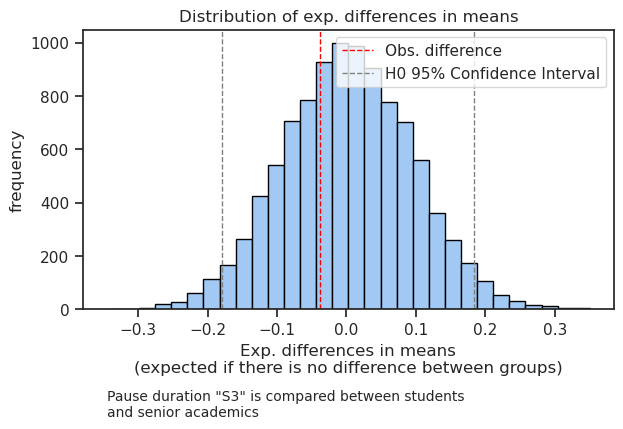

______________
S4
Статистика Хи-квадрат: 3.542631315116619e-27
P-значение: 1.0
Observed difference (standardized): 0.04129973576783143
CI for observed difference [-1.920257529223476, 2.002857000759139]
Cohen's d (effect size): 0.04126694823019011
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.9552
Нормальность средних разниц: p=0.0364
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.4203
П-значение для разницы дисперсий: 0.5753
Доверительный интервал для средней разницы H0: (-0.1000, 0.0962)
Эффект (Cohen's D): 0.0413


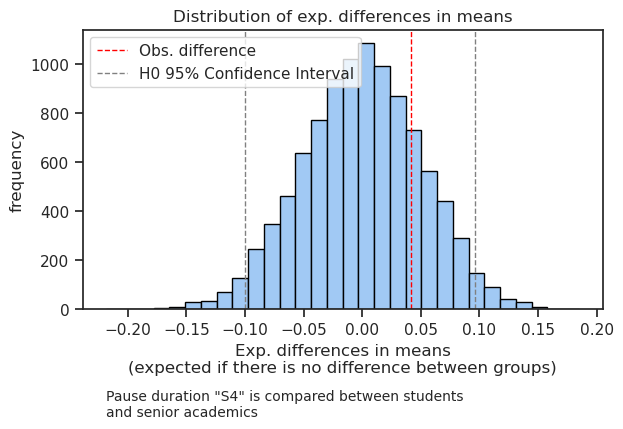

______________


In [174]:
pval = []
# es = []
pval_st = []
normality = []
dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'Pause duration'])
for i in st_paper_n_list:
    print (i)
    tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
    #
    # p_value_mean, normal, pst = full_bootstrap_analysis(tempdf, 'Pause duration')
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(tempdf, 'Pause duration')
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Pause duration ")
    paper_table.loc[len(paper_table)] = [f'Pause duration of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), 0, round(Crit_metric, 2), round(pst, 4), 0]
    dfj_boot = pd.concat([dfj_boot, tempdf])
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    print('______________')

# fdr correction
pval_st = multitest.fdrcorrection(pval_st)[1]
pval = multitest.fdrcorrection(pval)[1]

paper_table.loc[paper_table.index[-4:], 'Bootstrap p value corrected'] = pval
paper_table.loc[paper_table.index[-4:], 'Stat p value corrected'] = pval_st


In [73]:
# conf_interval = []
# pval = []
# es = []
# dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'Pause duration'])
# for i in sorted(dfj_s['strategy_paper_name'].unique()):
#     if i!='0':
#         print(i)
#         tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
#         ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(tempdf, 'Pause duration', f'Strategy "{i}".\n')
#         dfj_boot = pd.concat([dfj_boot, tempdf])
#         conf_interval.append(ci)
#         pval.append(p_value)
#         es.append(cohens_d)
#         print('\n')

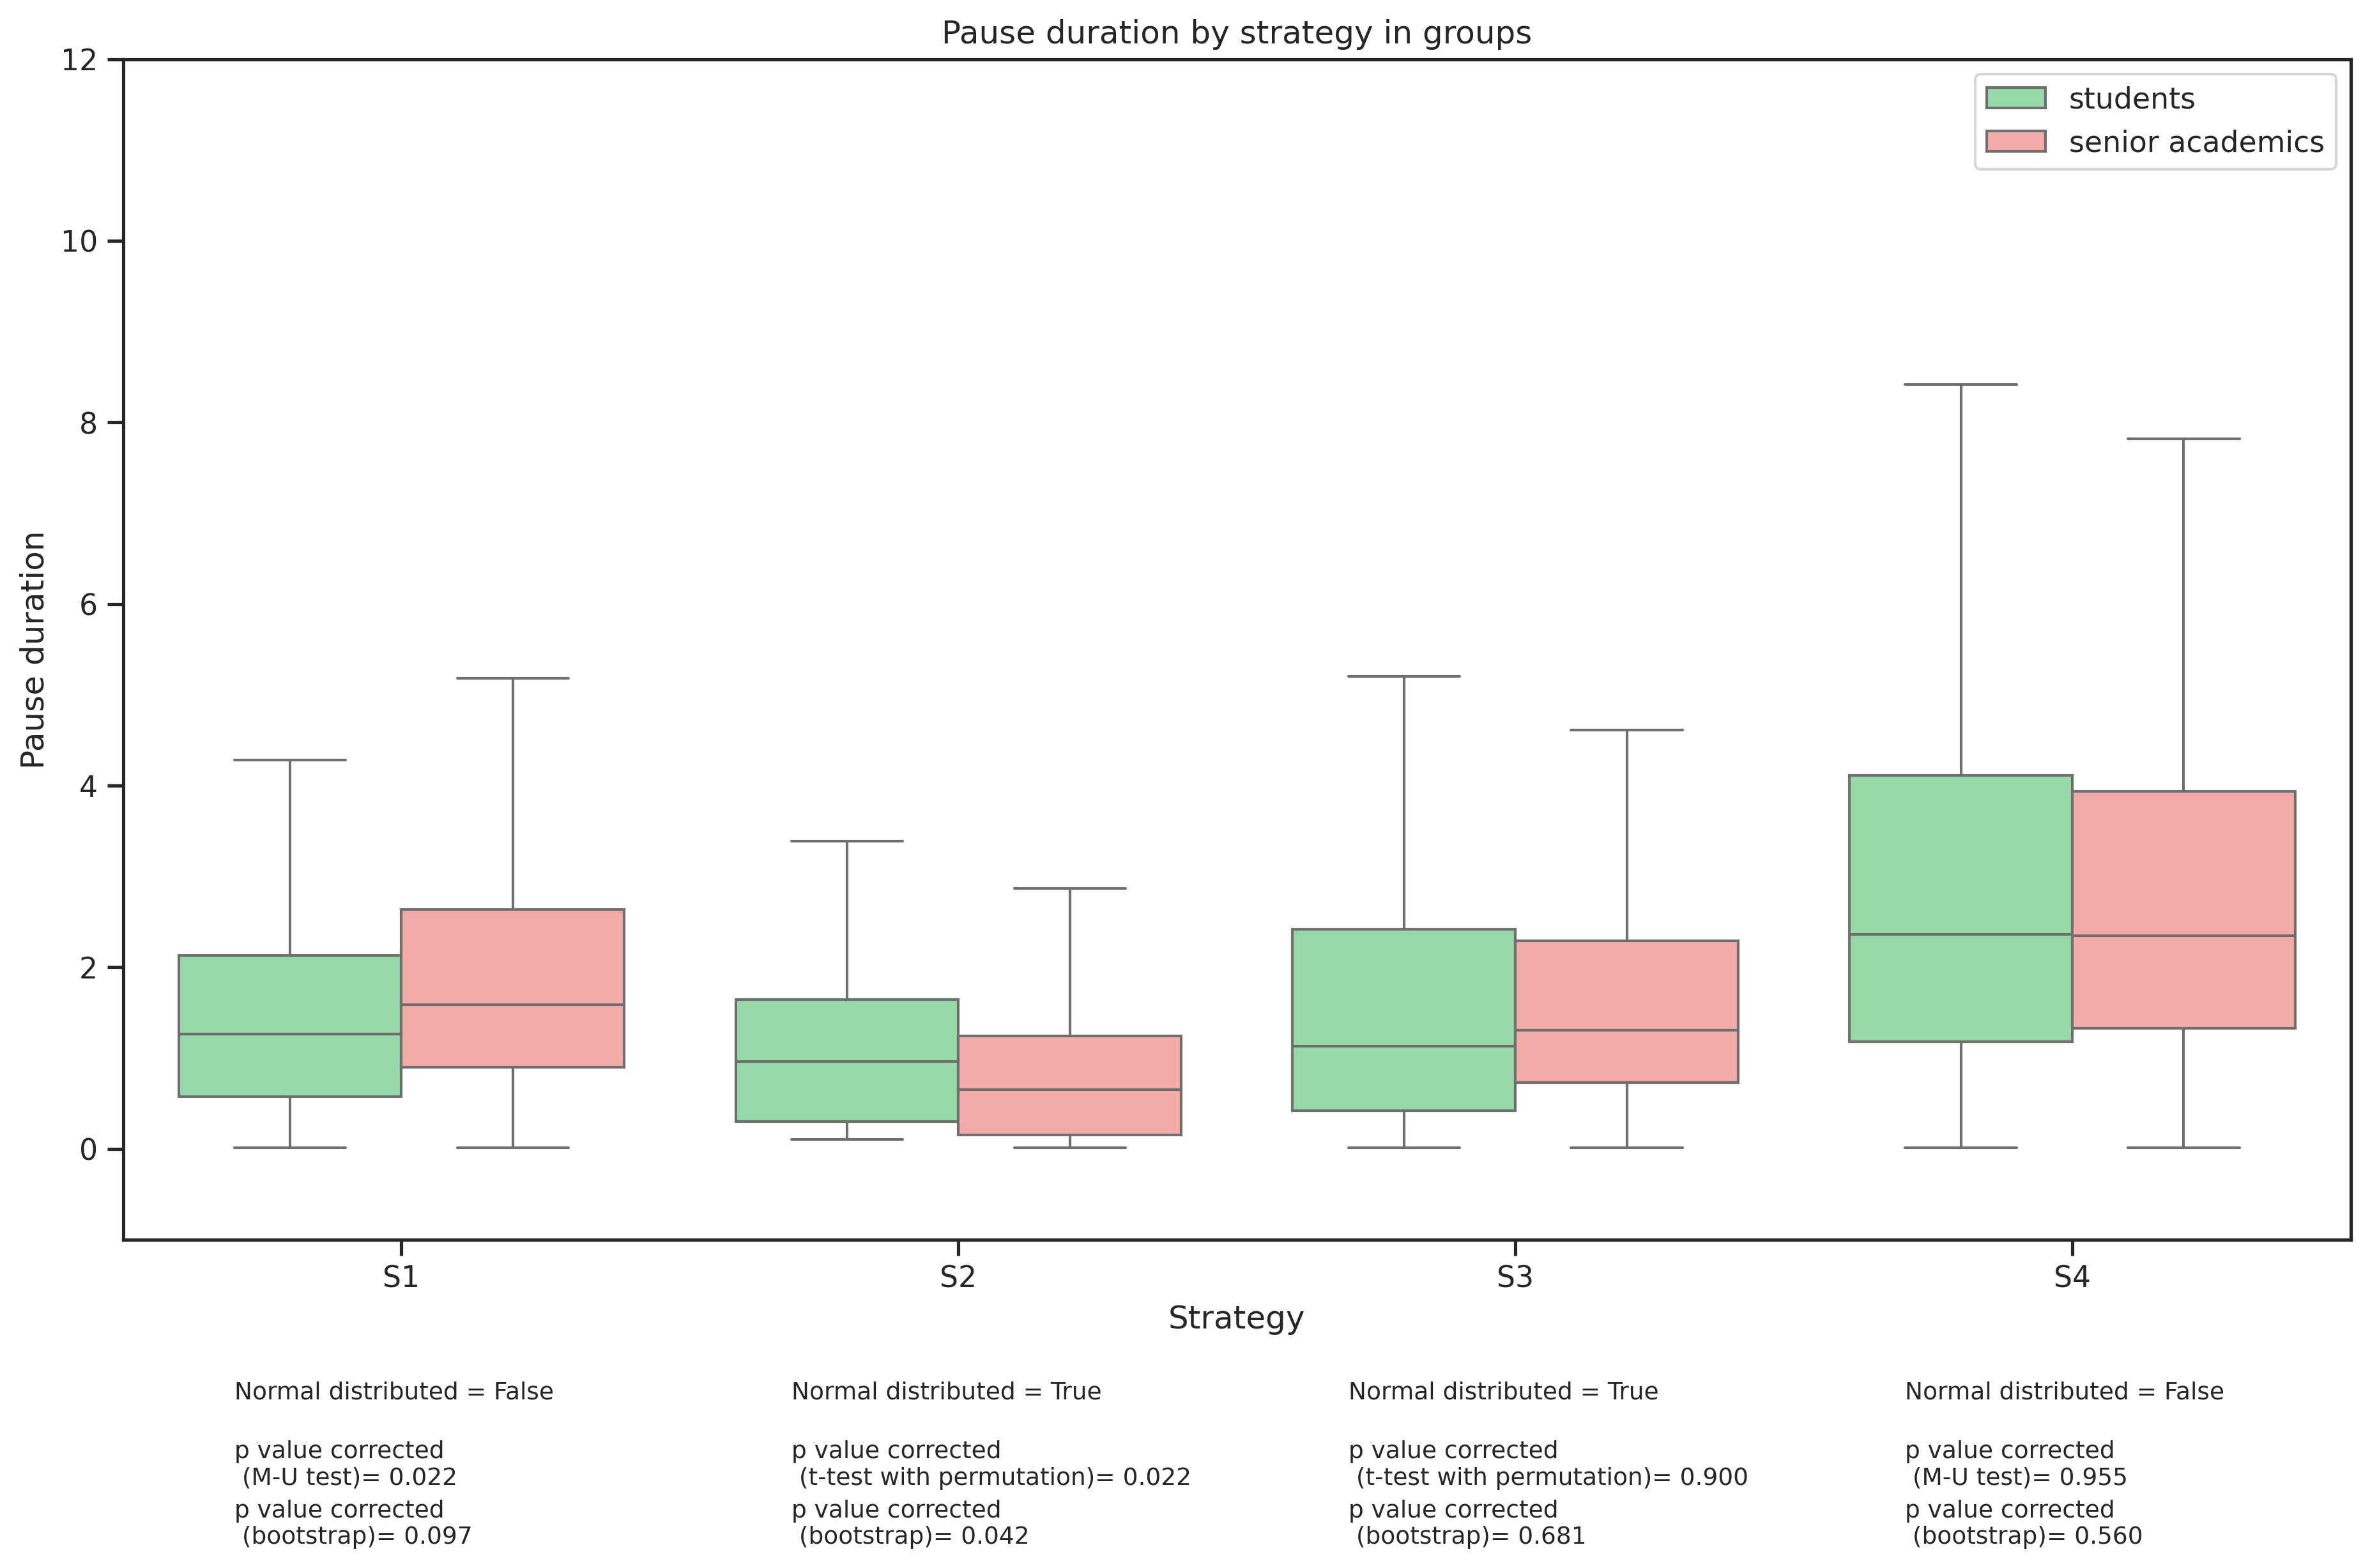

In [176]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Pause duration', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.ylim(-1, 12)

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(normality)):
      g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      if normality[i]:
            g.text(i*0.25+0.05, -0.17, f"p value corrected\n (t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      else:
            g.text(i*0.25+0.05, -0.17, f"p value corrected\n (M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value corrected\n (bootstrap)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
plt.xlabel('Strategy')
plt.title('Pause duration by strategy in groups')
fig.savefig(f'figures/Pause duration by strategy in groups.png', bbox_inches='tight')


In [177]:
dict_for_strategy_names_paper = {'phonetic strategy': 'S1',
                                 'derivative strategy': 'S2',
                                 'semantic-field strategy': 'S3',
                                 'individual association strategy': 'S4'
}

## word frequency

In [86]:
# ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(dfj[['type','Word frequency']], 'Word frequency')

In [112]:
# dfjj[['type', 'Word frequency', 'strategy_paper_name', 'order_letter']]

In [178]:
dfjj

,index,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,...,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name,Word frequency,Pause duration
1,1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,...,59,28,13,18,2.390357,students,individual association strategy,S4,220.0,0.10
2,2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,...,59,28,13,18,2.390357,students,phonetic strategy,S1,13.2,3.15
3,3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,...,59,28,13,18,2.390357,students,individual association strategy,S4,12.7,1.00
4,4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,...,59,28,13,18,2.390357,students,semantic-field strategy,S3,220.0,0.70
5,5,5,Б_В_10,1,повреждение,"['по', 'повреждение']",п,8,6.0,6,...,59,28,13,18,2.390357,students,individual association strategy,S4,18.5,3.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,2543,1268,pr_M_5,3,соболь,"['Санта', 'соболь']",с,8,17.0,43,...,47,16,10,21,3.550909,senior academics,individual association strategy,S4,3.3,4.55
2544,2544,1269,pr_M_5,3,Сахара,"['соболь', 'Сахара']",с,8,18.0,44,...,47,16,10,21,3.550909,senior academics,individual association strategy,S4,2.0,3.61
2545,2545,1270,pr_M_5,3,Севастополь,"['Сахара', 'Севастополь']",с,8,19.0,45,...,47,16,10,21,3.550909,senior academics,individual association strategy,S4,5.5,3.44
2546,2546,1271,pr_M_5,3,сугроб,"['Севастополь', 'сугроб']",с,3,20.0,46,...,47,16,10,21,3.550909,senior academics,semantic-field strategy,S3,11.1,3.37


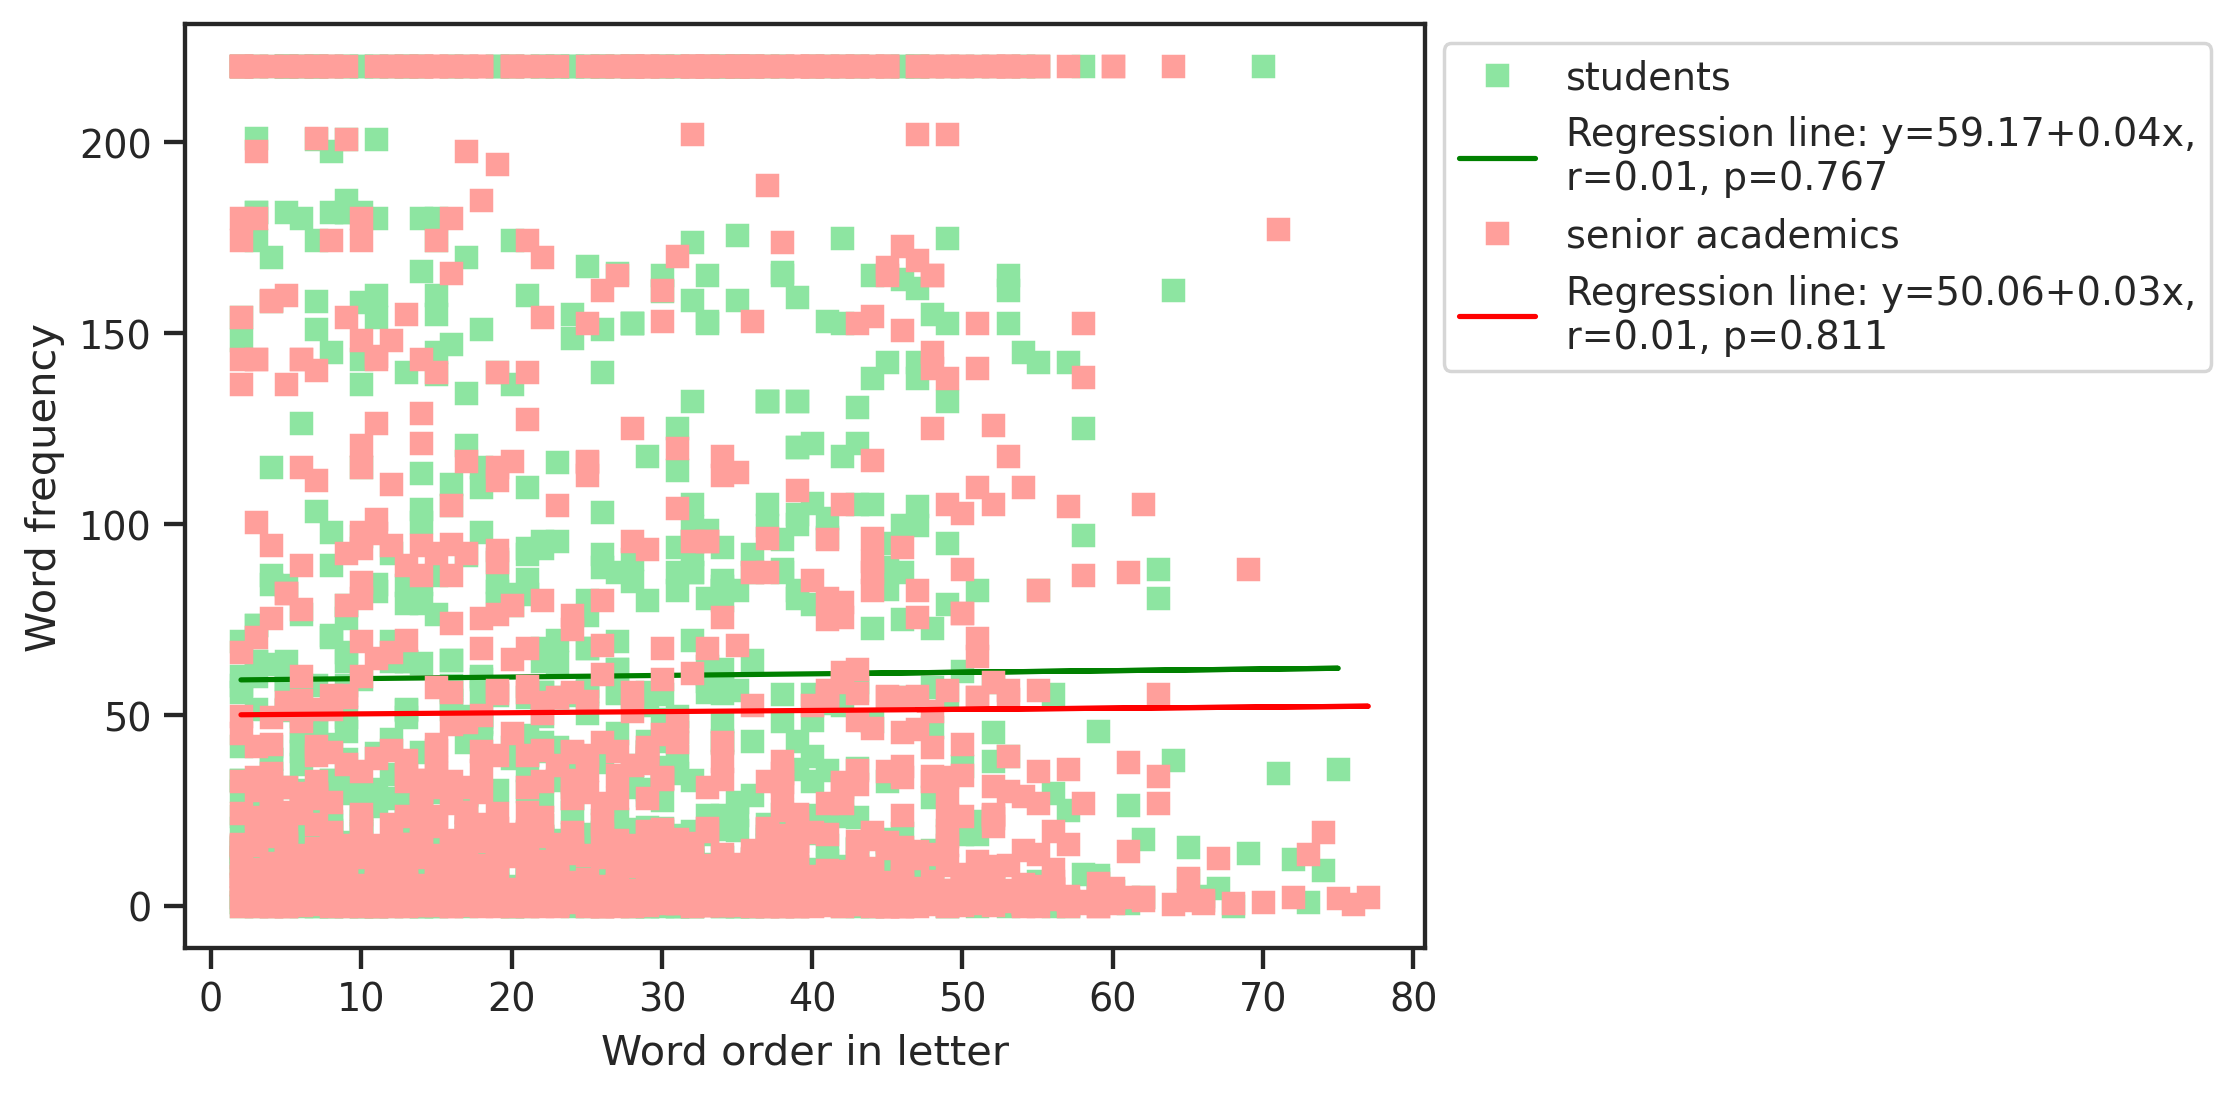

In [179]:
x1 = dfjj[dfjj['type']=='students']['order_whole_test'].values.astype(float)
y1 = dfjj[dfjj['type']=='students']['Word frequency'].values.astype(float)
x2 = dfjj[dfjj['type']!='students']['order_whole_test'].values.astype(float)
y2 = dfjj[dfjj['type']!='students']['Word frequency'].values.astype(float)

slope, intercept, r, p, stderr = stats.linregress(x1, y1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
fig, ax = plt.subplots(dpi=250)
# ax.set_color_cycle(['green', 'red'])
ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
ax.plot(x1, intercept + slope * x1, label=line, color='green')

slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

ax.set_xlabel('Word order in letter')
ax.set_ylabel('Word frequency')
ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# plt.tight_layout()

# ax.legend(facecolor='white')
plt.show()
fig.savefig(f'figures/Word order in letter ~ Word frequency.png', bbox_inches='tight')

### **between strategies**

In [180]:
dfj_s = dfjj[['type','Word frequency']]

In [92]:
# full_bootstrap_mean_diff(dfj_s, 'Word frequency', f'Strategy "{i}".\n')

In [181]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

S1
Статистика Хи-квадрат: 1.3856865644485547e-27
P-значение: 1.0
Observed difference (standardized): 0.058784918827033183
CI for observed difference [-1.912449693423513, 2.0300195310775795]
Cohen's d (effect size): 0.0584498872863443
Expected mean diffs are normal distributed
T-student p_value: 0.6574
Нормальность средних разниц: p=0.1178
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.6496
П-значение для разницы дисперсий: 0.9885
Доверительный интервал для средней разницы H0: (-0.2546, 0.2585)
Эффект (Cohen's D): 0.0584


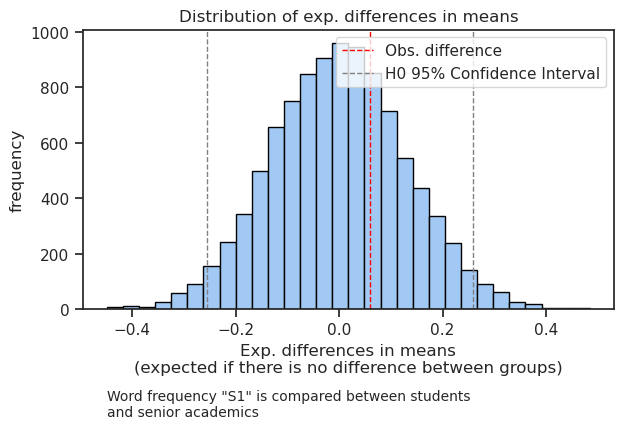

______________
S2
Статистика Хи-квадрат: 2.0004449143140616e-27
P-значение: 1.0
Observed difference (standardized): 0.2914096796996146
CI for observed difference [-1.6635317360205468, 2.246351095419776]
Cohen's d (effect size): 0.2921637280884141
Expected mean diffs are normal distributed
T-student p_value: 0.0489
Нормальность средних разниц: p=0.2154
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0465
П-значение для разницы дисперсий: 0.3059
Доверительный интервал для средней разницы H0: (-0.2890, 0.2863)
Эффект (Cohen's D): 0.2922


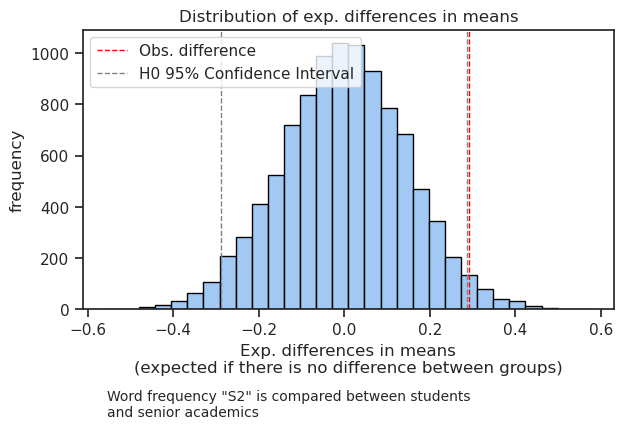

______________
S3
Статистика Хи-квадрат: 6.0369046525630625e-27
P-значение: 1.0
Observed difference (standardized): 0.14996653067154686
CI for observed difference [-1.8109304093018306, 2.1108634706449245]
Cohen's d (effect size): 0.14989793401392248
Expected mean diffs are normal distributed
T-student p_value: 0.1085
Нормальность средних разниц: p=0.6534
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.1071
П-значение для разницы дисперсий: 0.4485
Доверительный интервал для средней разницы H0: (-0.1849, 0.1861)
Эффект (Cohen's D): 0.1499


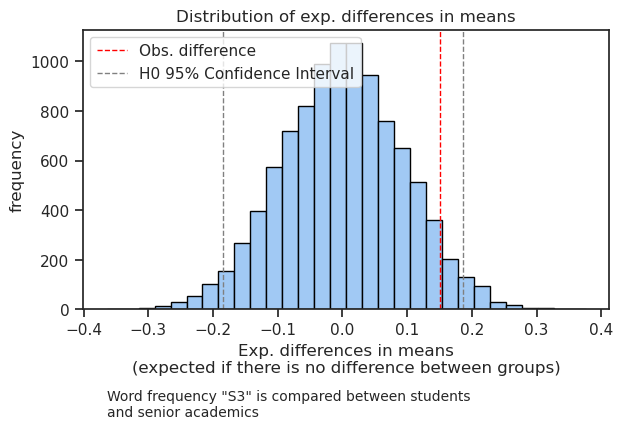

______________
S4
Статистика Хи-квадрат: 3.2584878401930925e-27
P-значение: 1.0
Observed difference (standardized): 0.1368477294846019
CI for observed difference [-1.8205655022597123, 2.094260961228916]
Cohen's d (effect size): 0.1370285770219295
Expected mean diffs are normal distributed
T-student p_value: 0.0094
Нормальность средних разниц: p=0.1832
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0085
П-значение для разницы дисперсий: 0.1336
Доверительный интервал для средней разницы H0: (-0.1017, 0.1028)
Эффект (Cohen's D): 0.1370


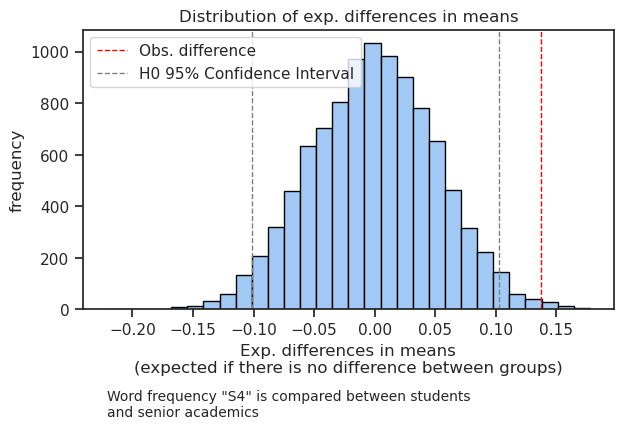

______________


In [182]:
pval = []
# es = []
pval_st = []
normality = []
dfj_boot = dfjj[['type', 'Word frequency', 'strategy_paper_name']]
for i in st_paper_n_list:
    print (i)
    tempdf = dfj_boot[dfj_boot['strategy_paper_name']==i]
    
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(tempdf, 'Word frequency')
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Word frequency ")
    paper_table.loc[len(paper_table)] = [f'Word frequency of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), 0, round(Crit_metric, 2), round(pst, 4), 0]
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    print('______________')

# fdr correction
pval_st = multitest.fdrcorrection(pval_st)[1]
pval = multitest.fdrcorrection(pval)[1]

paper_table.loc[paper_table.index[-4:], 'Bootstrap p value corrected'] = pval
paper_table.loc[paper_table.index[-4:], 'Stat p value corrected'] = pval_st   

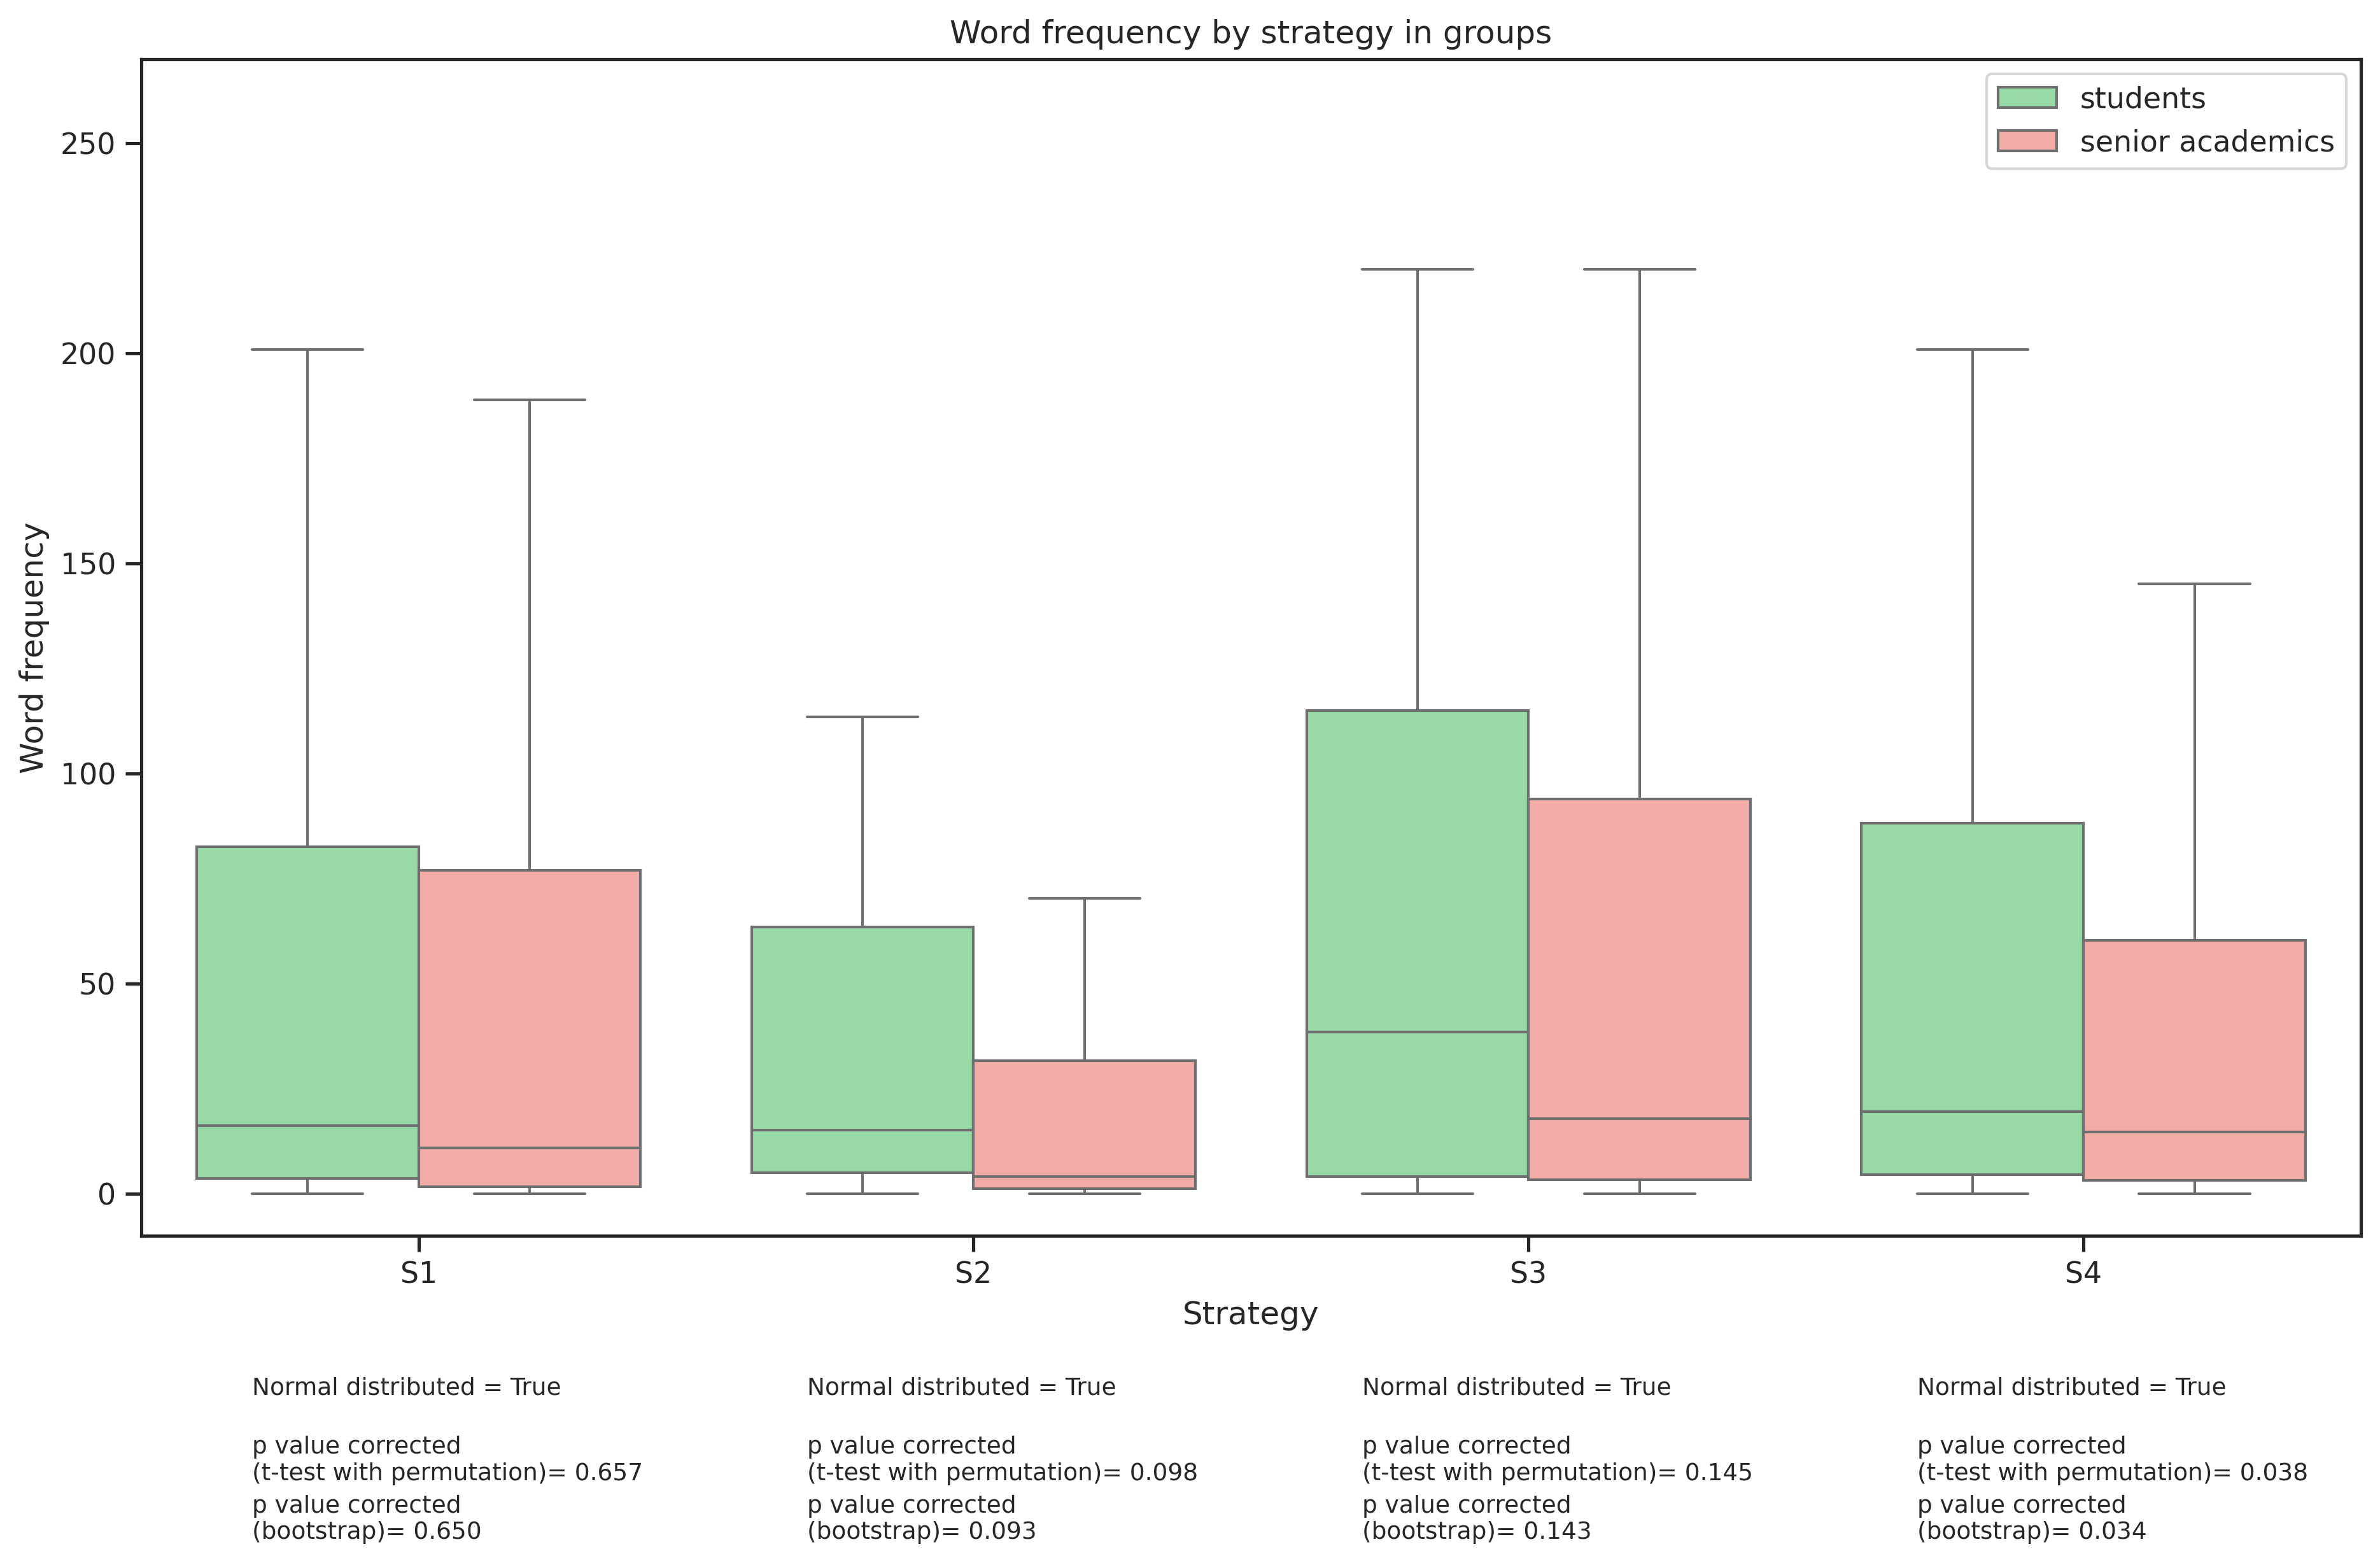

In [183]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.ylim((-10,270))

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
for i in range(len(normality)):
      g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
      if normality[i]:
            g.text(i*0.25+0.05, -0.17, f"p value corrected\n(t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      else:
            g.text(i*0.25+0.05, -0.17, f"p value corrected\n(M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      g.text(i*0.25+0.05, -0.22, f"p value corrected\n(bootstrap)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
plt.xlabel('Strategy')
plt.title('Word frequency by strategy in groups')
fig.savefig(f'figures/Word frequency by strategy in groups.png', bbox_inches='tight')


In [126]:
# fig = plt.figure(figsize=(10, 6), dpi=300)
# sns.set_theme(style="ticks", palette="pastel")
# g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
# plt.tight_layout()
# g.legend( bbox_to_anchor=(1.28, 1))
# plt.ylim((-10,270))

# for i in range(len(es)):
#       a = dfj_boot[(dfj_boot['type']!='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
#       b = dfj_boot[(dfj_boot['type']=='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
#       # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
#       T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)

#       g.text(i*0.25+0.05, -0.12, f"ES = {es[i]:.2f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
#       g.text(i*0.25+0.05, -0.17, f"p value = {pval[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       g.text(i*0.25+0.05, -0.22, f"p value (t test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
    
# g.legend( bbox_to_anchor=(0.75, 0.85))
# # fig.suptitle('Word frequency by strategy in groups', fontsize=15)
# g.set_title('Word frequency by strategy in groups', fontdict={'fontsize': 15, 'fontweight': 'medium'})
# plt.xlabel('strategy_name')
# plt.show()

## word in tertiles

In [184]:
words = pd.read_csv('words.tsv', sep='\t')
words.head(2)

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,NaN,п,NaN,1.0,1,152.7,...,NaN,NaN,59,28,13,18,2.390357,students,NaN,NaN
1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,204.2,...,NaN,NaN,59,28,13,18,2.390357,students,individual association strategy,S4


In [185]:
words.columns

Index(['Unnamed: 0', 'ID', 'quota sec', 'word', 'previous + word',
       'first_letter', 'strategy', 'order_letter', 'order_whole_test',
       'frequency', 'pause', 'VP', 'VS', 'N of words', 'N of words_P',
       'N of words_O', 'N of words_S', 'mean pause', 'type', 'strategy_name',
       'strategy_paper_name'],
      dtype='object')

In [186]:
words[['quota sec', 'type', 'frequency']].groupby(['quota sec', 'type']).mean()

frequency
quota sec type                        
1         senior academics   91.554325
          students          134.849896
2         senior academics   69.398642
          students          189.809972
3         senior academics   91.522465
          students          121.710216

In [187]:
words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID'], as_index=False).count()

,quota sec,type,ID,word
0,1,senior academics,pr_A_1,20
1,1,senior academics,pr_B_1,22
2,1,senior academics,pr_E_1,22
3,1,senior academics,pr_G_1,24
4,1,senior academics,pr_I_1,20
...,...,...,...,...
148,3,students,Ф_Д_2,9
149,3,students,Х_М_3,10
150,3,students,Ш_А_26,11
151,3,students,Ш_Ю_23,13


In [188]:
word_counts = words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID'], as_index=False).count().drop('ID', axis=1)
wcounts_groups = word_counts.groupby(['quota sec', 'type'])['word'].apply(list)

In [189]:
wcounts_groups.keys()

MultiIndex([(1, 'senior academics'),
            (1,         'students'),
            (2, 'senior academics'),
            (2,         'students'),
            (3, 'senior academics'),
            (3,         'students')],
           names=['quota sec', 'type'])

In [190]:
for key in wcounts_groups.keys():
    print(key, stats.shapiro(wcounts_groups[key]))

(1, 'senior academics') ShapiroResult(statistic=0.9790192758357609, pvalue=0.8649974983499225)
(1, 'students') ShapiroResult(statistic=0.9094829633515495, pvalue=0.022191155217374116)
(2, 'senior academics') ShapiroResult(statistic=0.9768191144141316, pvalue=0.8308157394685582)
(2, 'students') ShapiroResult(statistic=0.9481573355153016, pvalue=0.1933483149567224)
(3, 'senior academics') ShapiroResult(statistic=0.8984916716061329, pvalue=0.023536598350061857)
(3, 'students') ShapiroResult(statistic=0.9440957571448886, pvalue=0.15373077597042362)


In [191]:
# anova
anova = stats.kruskal(*wcounts_groups)
print(anova)

KruskalResult(statistic=87.3098032365469, pvalue=2.466980417583946e-17)


In [192]:
# m-u test
ter1_mu = stats.mannwhitneyu(wcounts_groups[(1, 'senior academics')], wcounts_groups[(1, 'students')])
ter2_mu = stats.mannwhitneyu(wcounts_groups[(2, 'senior academics')], wcounts_groups[(2, 'students')])
ter3_mu = stats.mannwhitneyu(wcounts_groups[(3, 'senior academics')], wcounts_groups[(3, 'students')])

print(f'tertile 1 {ter1_mu}')
print(f'tertile 2 {ter2_mu}')
print(f'tertile 3 {ter3_mu}')

tertile 1 MannwhitneyuResult(statistic=325.5, pvalue=0.8323678354938316)
tertile 2 MannwhitneyuResult(statistic=369.0, pvalue=0.3988294772784958)
tertile 3 MannwhitneyuResult(statistic=528.5, pvalue=2.1589238583441146e-05)


In [258]:
tertiles_corrected = multitest.fdrcorrection([ter1_mu.pvalue,ter2_mu.pvalue, ter3_mu.pvalue])
tertiles_corrected

(array([False, False,  True]),
 array([8.32367835e-01, 5.98244216e-01, 6.47677158e-05]))

In [194]:
wcounts_dependent = (words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID'], as_index=False).count()
 ).pivot(index=['ID', 'type'], columns='quota sec', values='word' ).reset_index(drop=False)
wcounts_dependent.head()

quota sec,ID,type,1,2,3
0,pr_A_1,senior academics,20.0,12.0,15.0
1,pr_B_1,senior academics,22.0,17.0,15.0
2,pr_E_1,senior academics,22.0,13.0,20.0
3,pr_G_1,senior academics,24.0,18.0,16.0
4,pr_I_1,senior academics,20.0,18.0,13.0


In [196]:
# stud behavior in tertiles
stud_12 = stats.wilcoxon(x = wcounts_dependent[wcounts_dependent['type']!='senior academics'][1].values.astype(int)
                         , y =wcounts_dependent[wcounts_dependent['type']!='senior academics'][2].values.astype(int)
                         , method='exact')
stud_23 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']!='senior academics'][2].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']!='senior academics'][3].values.astype(int))
stud_13 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']!='senior academics'][1].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']!='senior academics'][3].values.astype(int))
print(f'stud_12 {stud_12}')
print(f'stud_23 {stud_23}')
print(f'stud_13 {stud_13}')

stud_12 WilcoxonResult(statistic=0.0, pvalue=7.976447184692851e-06)
stud_23 WilcoxonResult(statistic=50.0, pvalue=0.0024141493293099027)
stud_13 WilcoxonResult(statistic=0.0, pvalue=1.4901161193847656e-08)


In [259]:
stud_tertiles_corrected = multitest.fdrcorrection([stud_12.pvalue,stud_23.pvalue, stud_13.pvalue])
stud_tertiles_corrected

(array([ True,  True,  True]),
 array([1.19646708e-05, 2.41414933e-03, 4.47034836e-08]))

In [198]:
# prof behavior in tertiles
prof_12 = stats.wilcoxon(x = wcounts_dependent[wcounts_dependent['type']=='senior academics'][1].values.astype(int)
                         , y =wcounts_dependent[wcounts_dependent['type']=='senior academics'][2].values.astype(int)
                         , method='exact')
prof_23 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']=='senior academics'][2].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']=='senior academics'][3].values.astype(int))
prof_13 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']=='senior academics'][1].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']=='senior academics'][3].values.astype(int))
print(f'prof_12 {prof_12}')
print(f'prof_23 {prof_23}')
print(f'prof_13 {prof_13}')

prof_12 WilcoxonResult(statistic=26.0, pvalue=0.00038747029312425913)
prof_23 WilcoxonResult(statistic=90.5, pvalue=0.24175330397156958)
prof_13 WilcoxonResult(statistic=58.5, pvalue=0.0041751861572265625)


In [260]:
prof_tertiles_corrected = multitest.fdrcorrection([prof_12.pvalue,prof_23.pvalue, prof_13.pvalue])
prof_tertiles_corrected

(array([ True, False,  True]), array([0.00116241, 0.2417533 , 0.00626278]))

In [261]:
word_counts

,quota sec,type,word
0,1,senior academics,20
1,1,senior academics,22
2,1,senior academics,22
3,1,senior academics,24
4,1,senior academics,20
...,...,...,...
148,3,students,9
149,3,students,10
150,3,students,11
151,3,students,13


In [269]:
tertiles_corrected[1]

array([8.32367835e-01, 5.98244216e-01, 6.47677158e-05])

In [275]:
1/3

0.3333333333333333

Text(0.5, 1.0, 'Word counts by tertiles in groups')

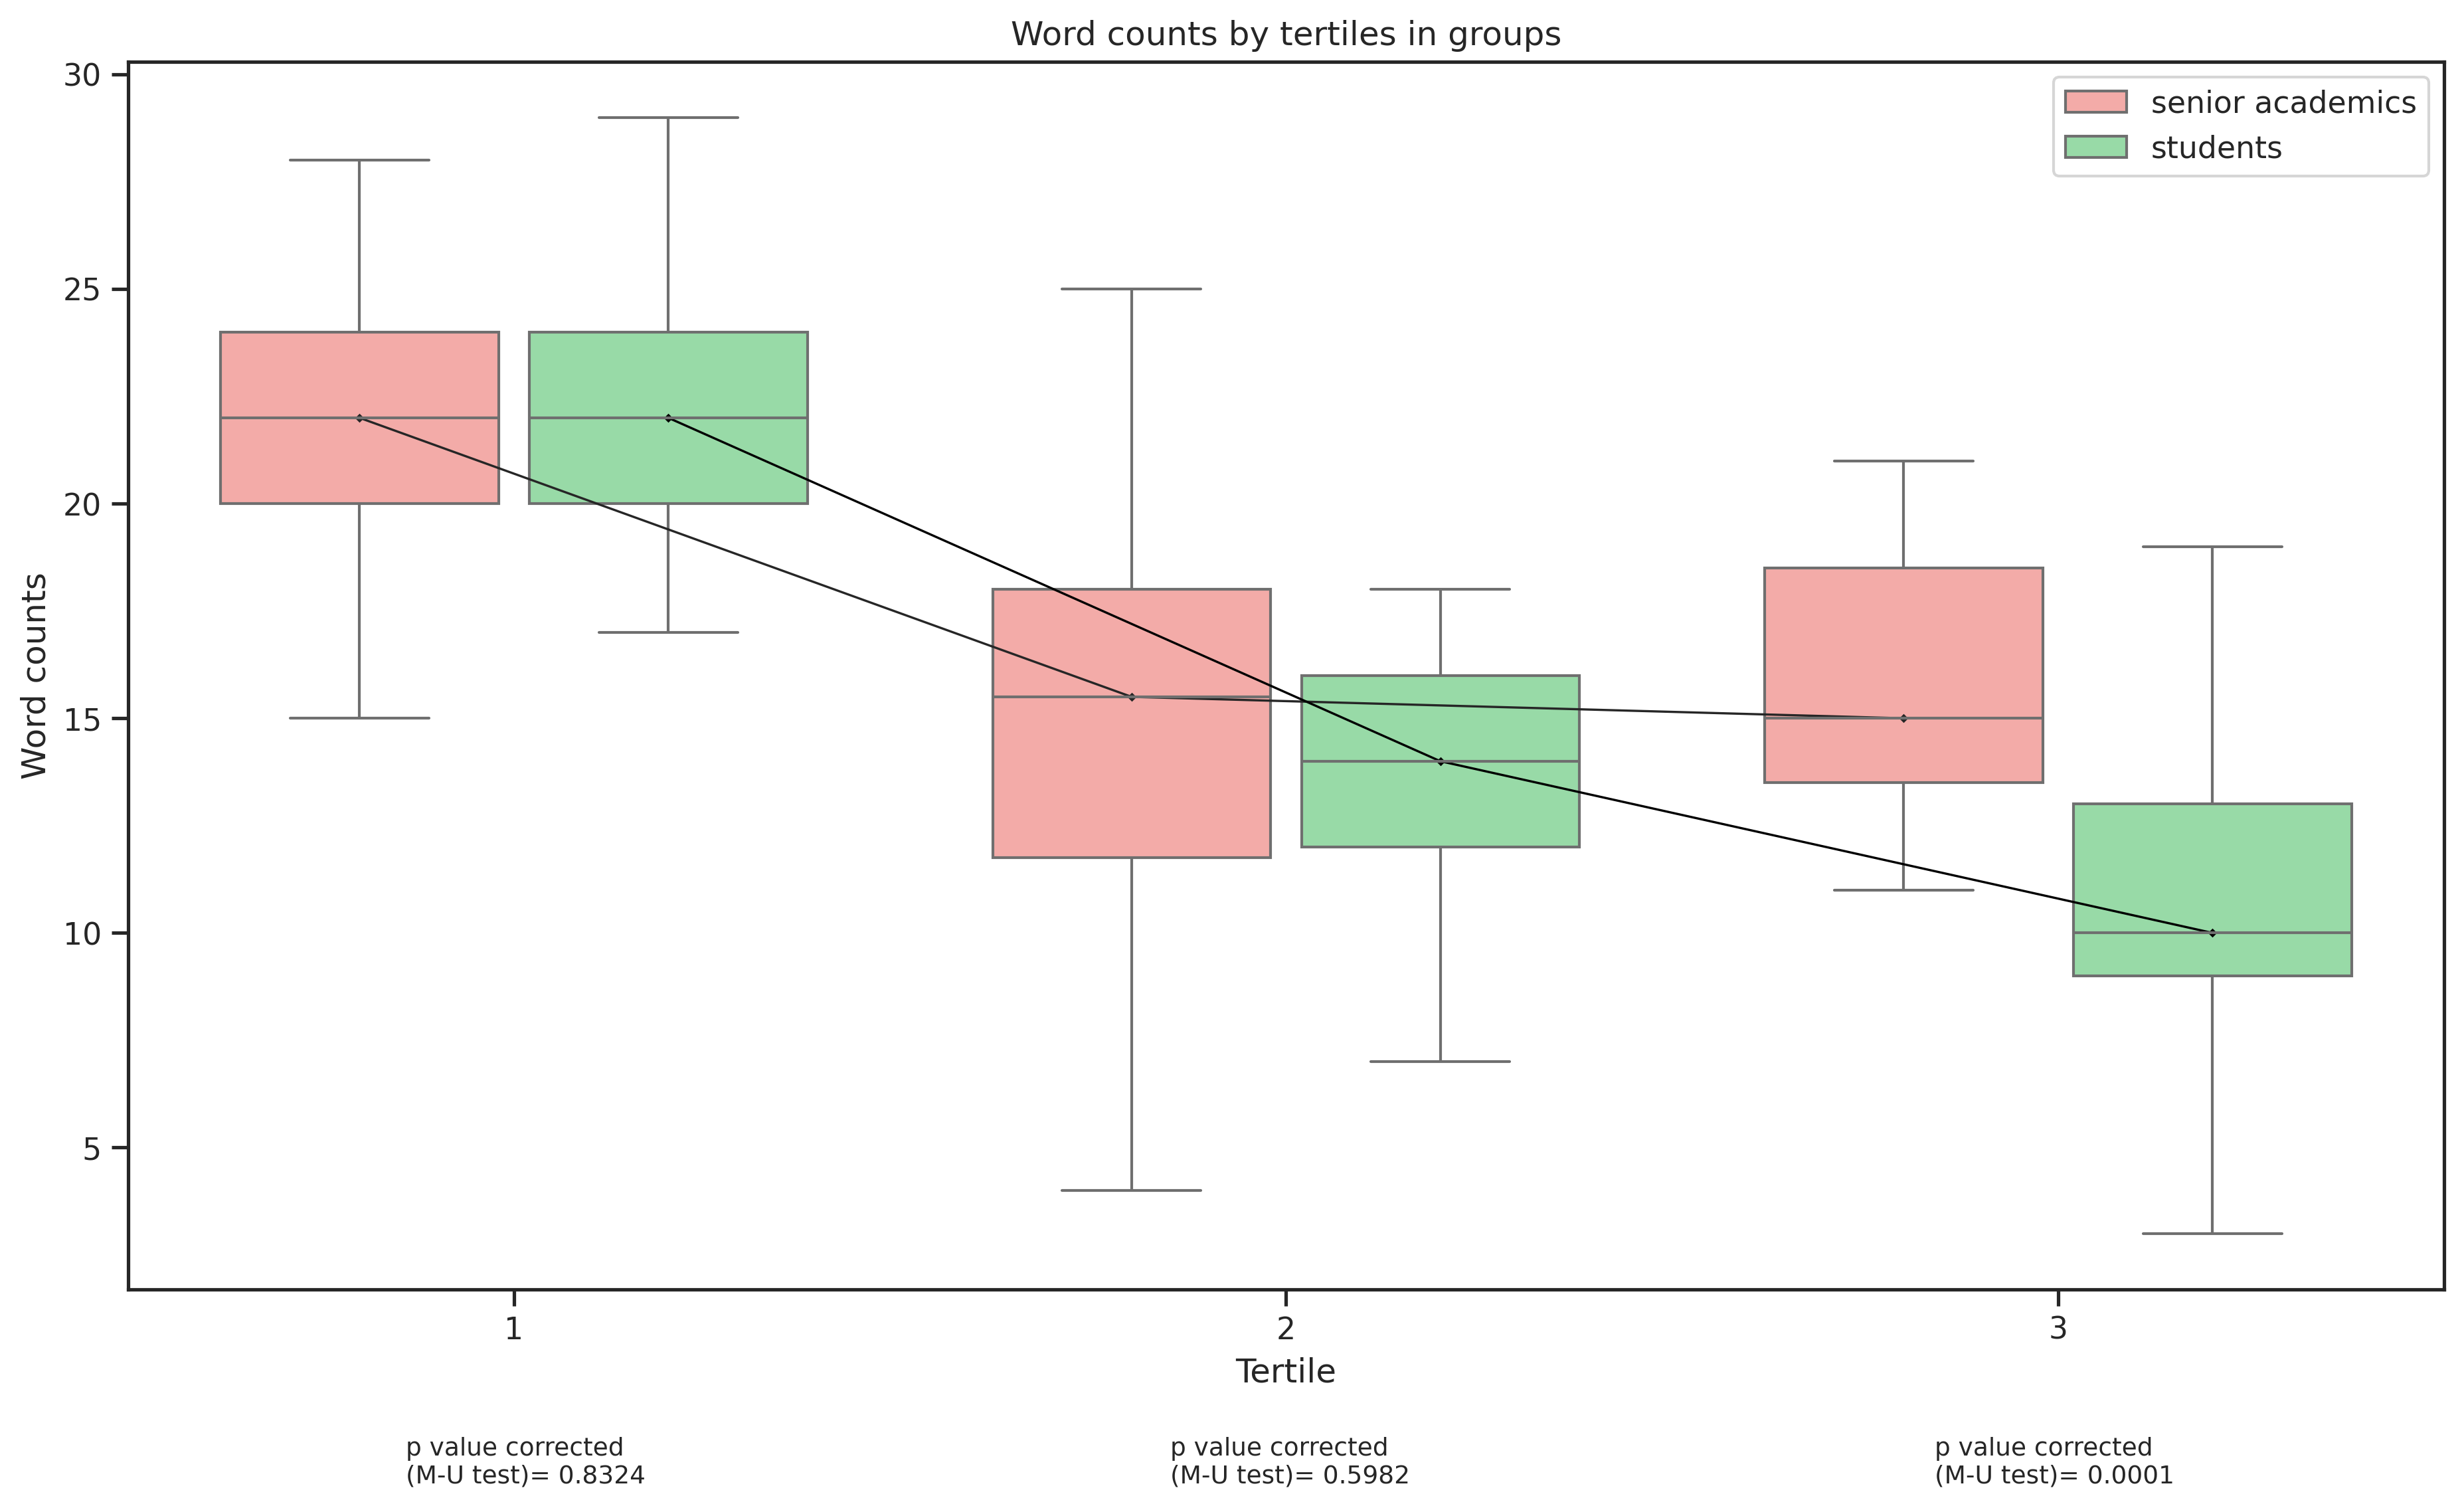

In [295]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = word_counts.sort_values(['quota sec']), x='quota sec',y='word', hue='type'
                , palette={'senior academics':'r', 'students':'g'}, showfliers = False
                , gap=.1
                # , showmeans=True
                # , dodge=False
                );
sns.pointplot(data=word_counts.sort_values(['quota sec']), x='quota sec', y='word', hue='type', ci=None
              , estimator='median'
              ,dodge=.8 - .8 / 2
              , scale=0.3, color='black', marker='D'
              , legend=False
              )


# g.set_title('Word counts by tertiles in groups')

# g.text(-0.5, -1.2, f"p values corrected\n(M-U test)= "
#              , fontsize = 9 , ha="left", va="top")
for i in range(3):
      g.text(i*(0.33)+0.12, -0.12, f"p value corrected\n(M-U test)= {tertiles_corrected[1][i]:.4f}"
             , fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
g.legend( bbox_to_anchor=(1, 1))
plt.ylabel('Word counts')
plt.xlabel('Tertile')
plt.title('Word counts by tertiles in groups')
# fig.savefig(f'figures/Word counts by tertiles in groups', bbox_inches='tight')

In [11]:
# words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID']).count().groupby(['quota sec', 'type']).mean()

In [12]:
# words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type'], as_index=False).agg(func=lambda x: len(x))

# RT

In [200]:
rt = pd.read_csv('results_academic_student.csv', sep=';' )
rt.head()

,participant,mean_rt,group
0,12014,0.608103,senior academics
1,2001,0.537719,senior academics
2,2005,0.863233,senior academics
3,9001,0.801409,senior academics
4,9002,0.564224,senior academics


In [201]:
# rt_full = pd.read_csv('combined_shape_trials.csv', dtype = {'participant': 'str', 'accuracy' : 'float', 'rt':'float'})
rt_full = pd.read_csv('combined_shape_trials.csv')
rt_full['participant'] = pd.to_numeric(rt_full['participant'], downcast='integer')
rt_full = rt_full[(rt_full['accuracy']==1 ) & (~rt_full['participant'].isna())]
# rt_full['participant']= rt_full['participant'].fillna(0).astype('int64')
rt_full['participant']= rt_full['participant'].astype('int64')
rt_full = rt_full.merge(rt[['group', 'participant']], on='participant', how='inner')
rt_full.head(2)


,participant,accuracy,rt,group
0,12001,1,1.053446,senior academics
1,12001,1,1.504920,senior academics


In [202]:
rt_full['participant'].nunique()

46

Статистика Хи-квадрат: 5.067472642407016e-27
P-значение: 1.0
Observed difference (standardized): -0.49768749012000635
CI for observed difference [-2.457911355217492, 1.4625363749774793]
Cohen's d (effect size): -0.4976306522962879
Expected mean diffs are normal distributed
T-student p_value: 0.0879
Нормальность средних разниц: p=0.2498
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0912
П-значение для разницы дисперсий: 0.8534
Доверительный интервал для средней разницы H0: (-0.5752, 0.5693)
Эффект (Cohen's D): -0.4976


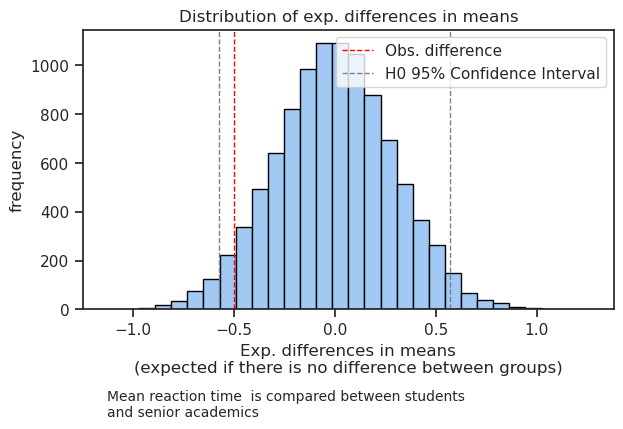

In [203]:
mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(rt, 'mean_rt', type_col='group')
plot_bresults(mean_expected_diffs, delta, ci_mean, col='', text_add="Mean reaction time ")

paper_table.loc[len(paper_table)] = ['Mean reaction time', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4), round(pst, 4)]



In [204]:
a = rt[(rt['group']!='students')]['mean_rt' + '_standardized'].values
b = rt[(rt['group']=='students')]['mean_rt' + '_standardized'].values
T_o , p_ond = stats.ttest_ind(a, b, permutations=1000, alternative='greater')

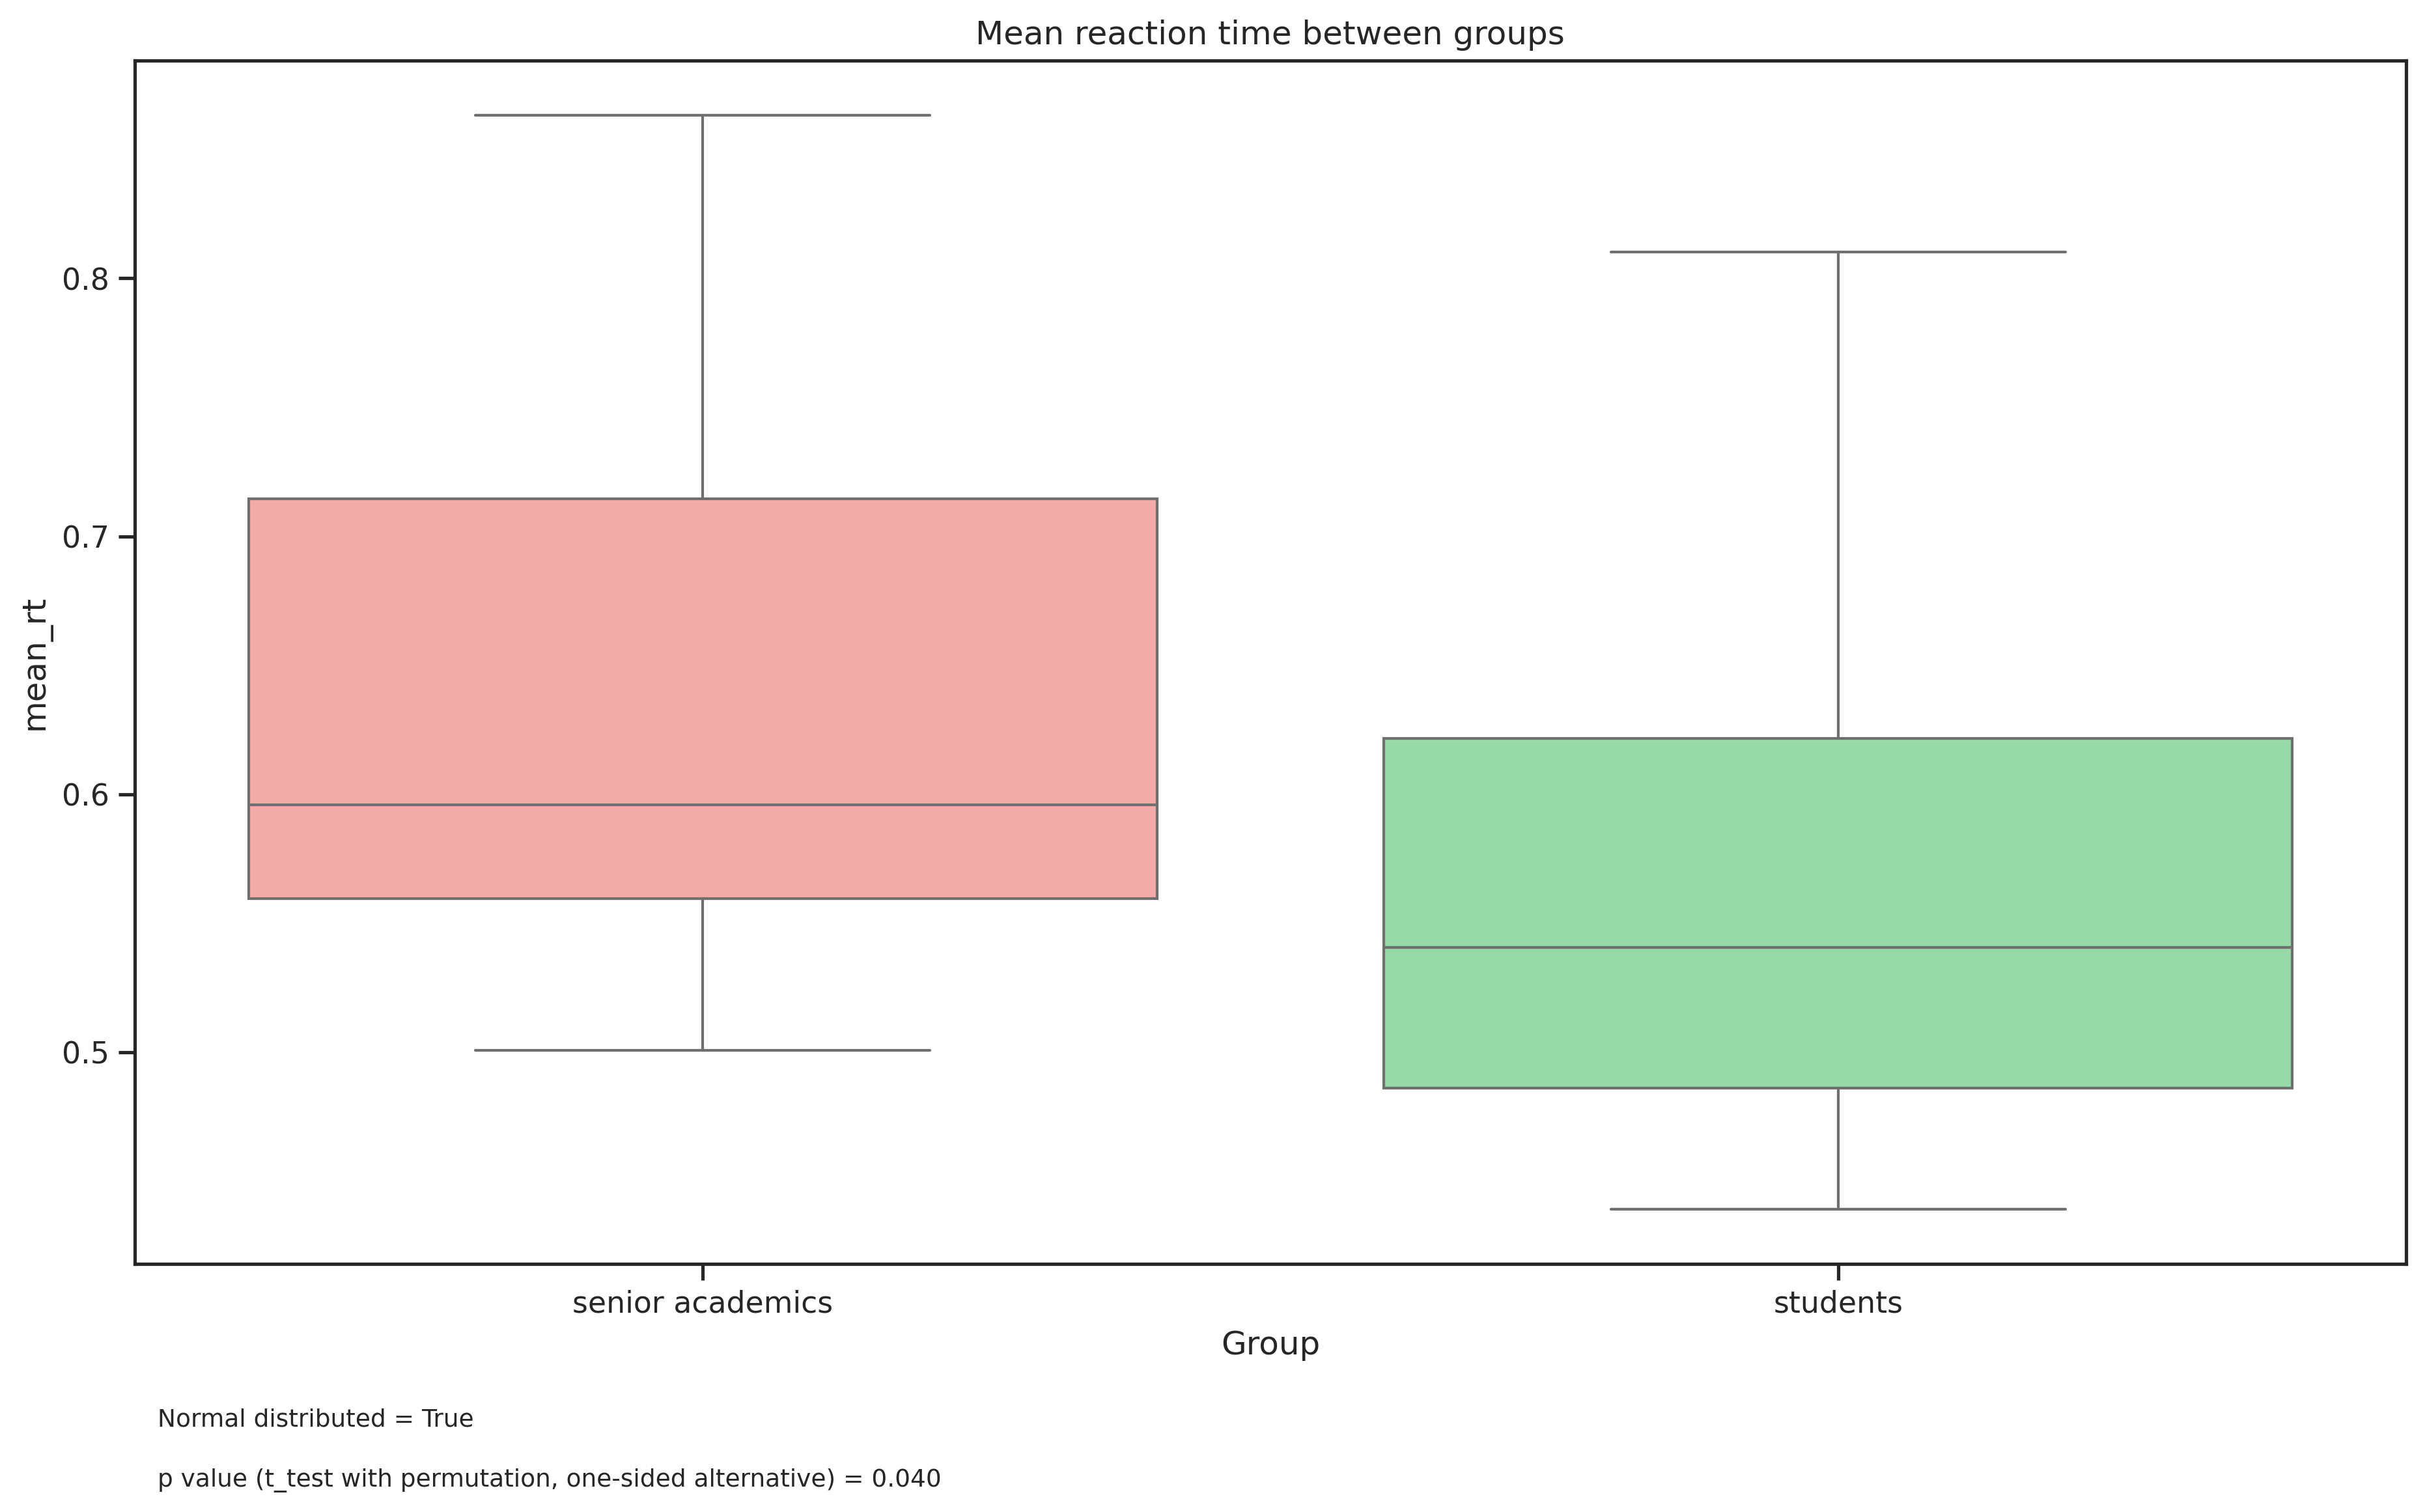

In [205]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt, y='mean_rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
if 1:
      g.text(0.01
             , -0.17, f"p value (t_test with permutation, one-sided alternative) = {p_ond:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      
# g.text(0.01, -0.22, f"p value (bootstrap)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
plt.xlabel('Group')
plt.title('Mean reaction time between groups')
fig.savefig(f'figures/Mean reaction time between groups one-sided.png', bbox_inches='tight')

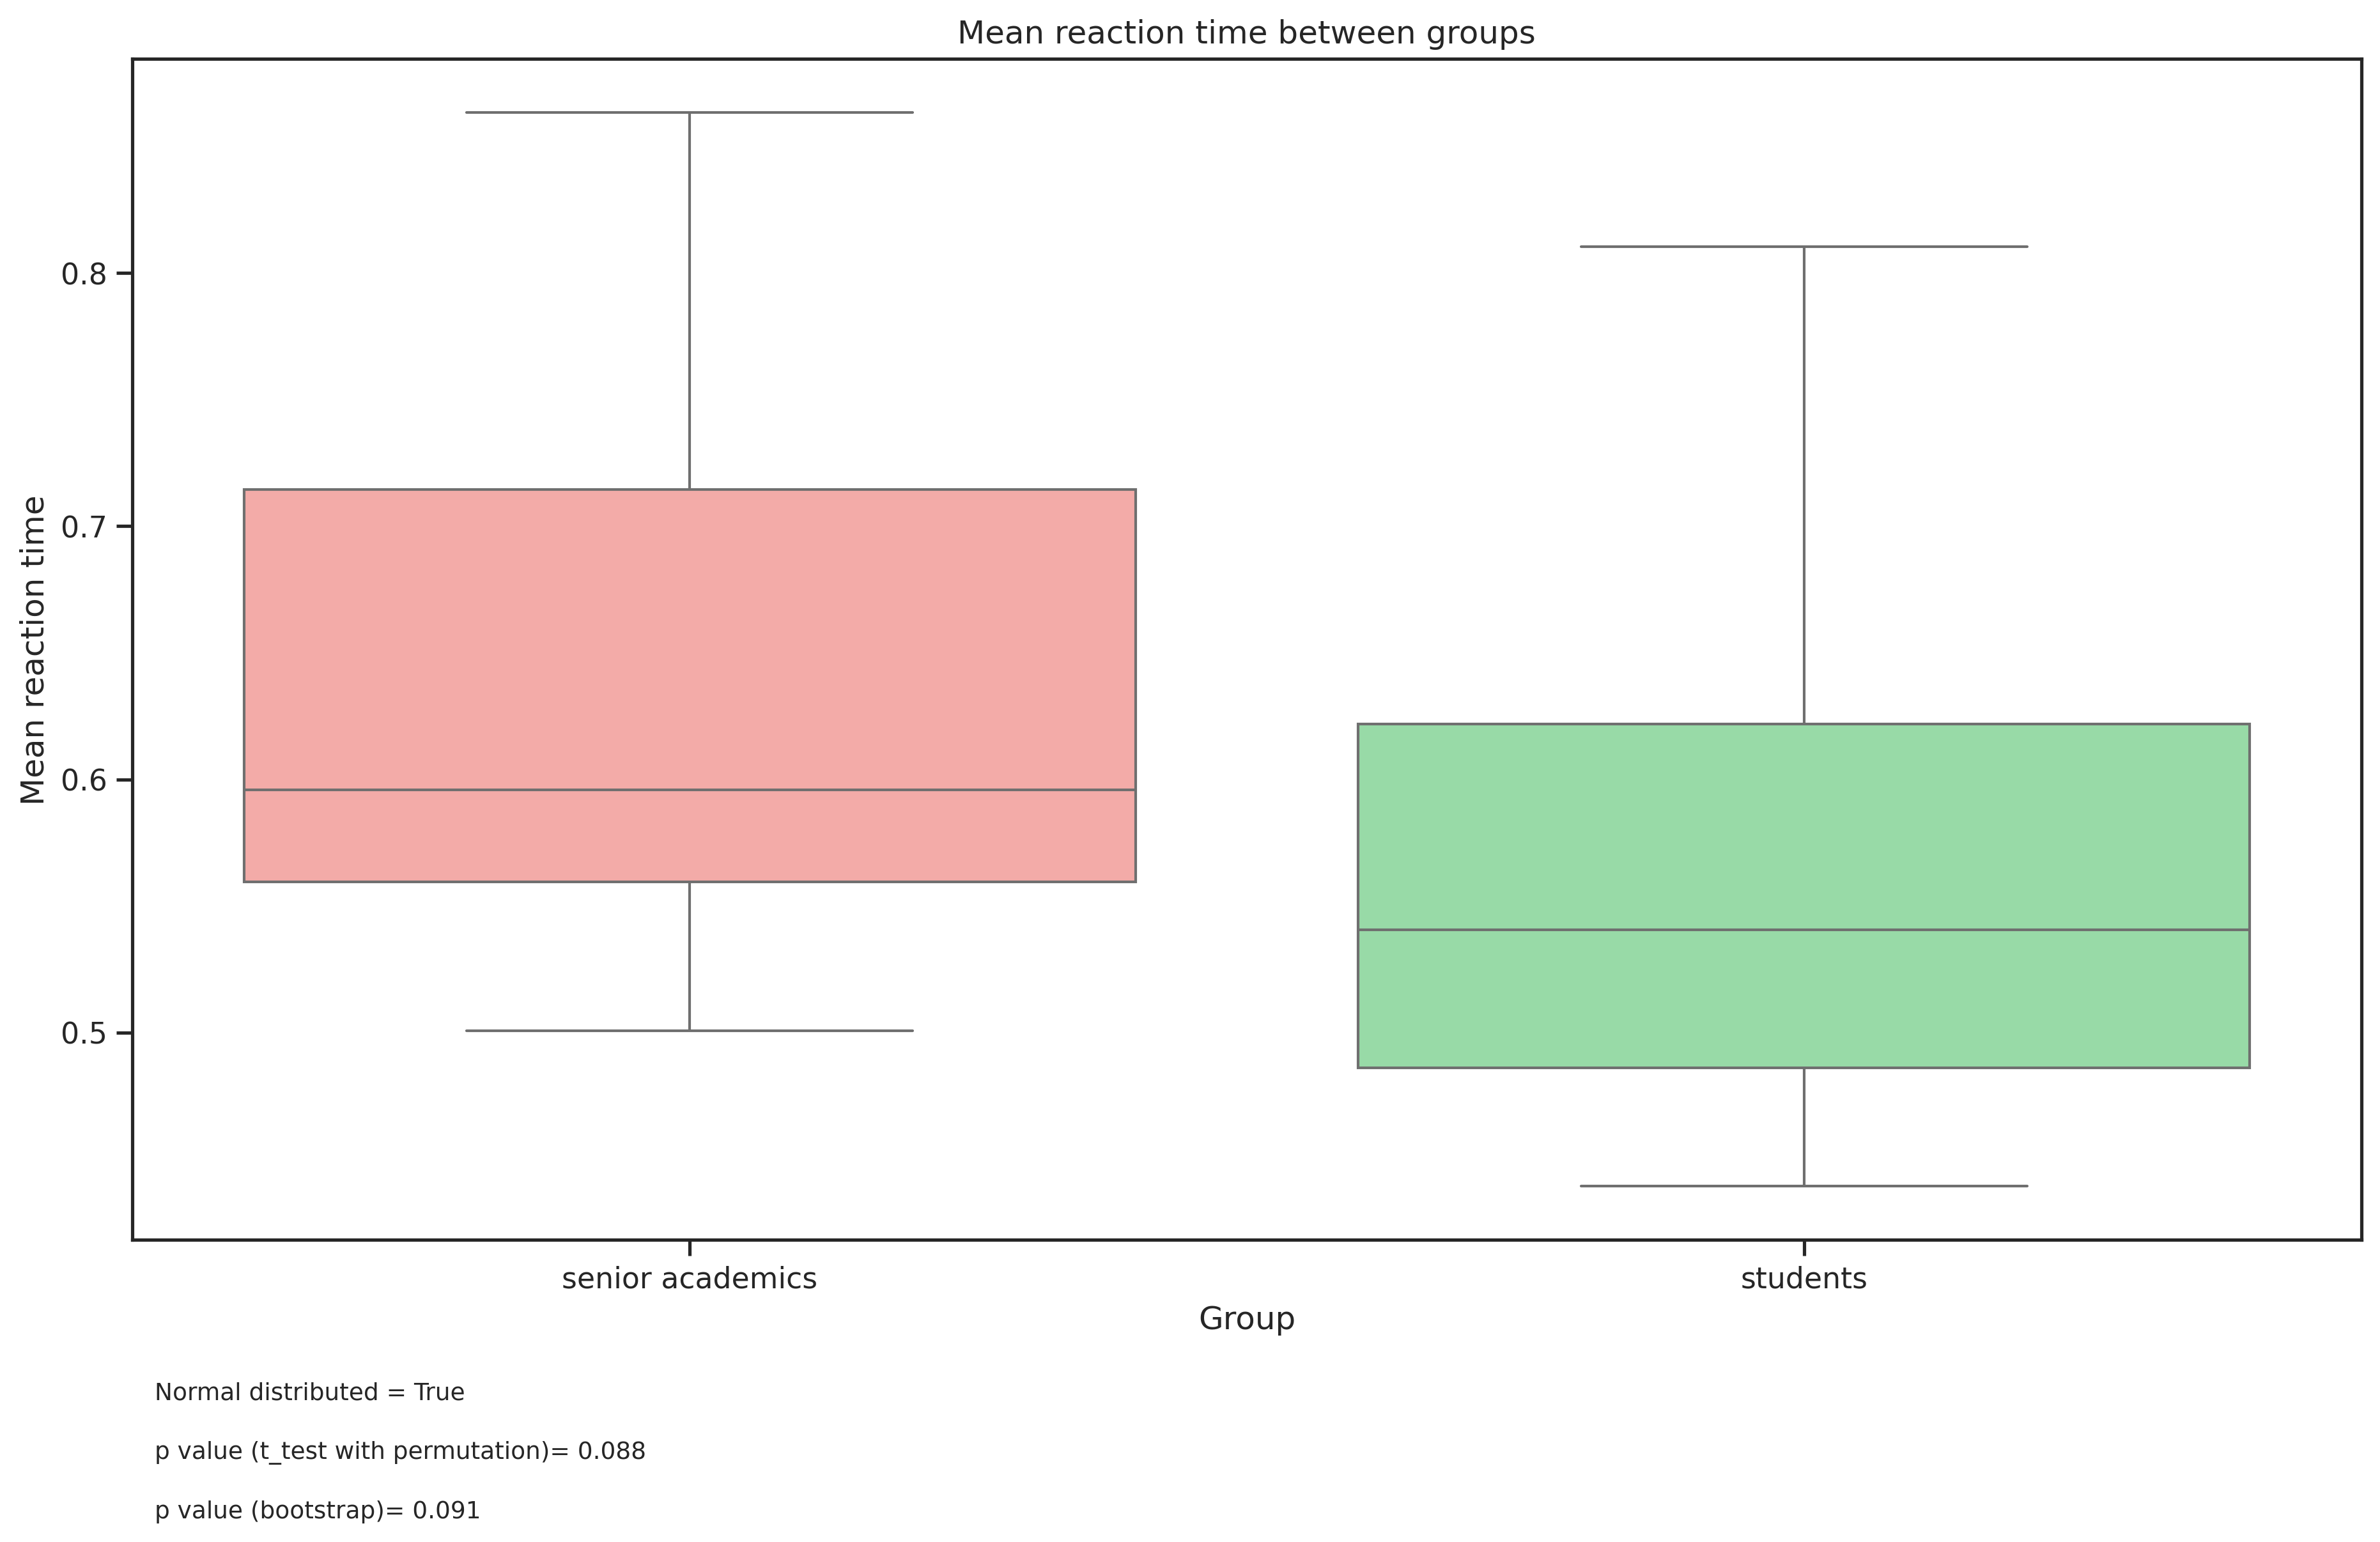

In [206]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt, y='mean_rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
if 1:
      g.text(0.01
             , -0.17, f"p value (t_test with permutation)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
else:
      g.text(-0.25-0.05, -0.17, f"p value (M-U test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
g.text(0.01, -0.22, f"p value (bootstrap)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
plt.xlabel('Group')
plt.ylabel('Mean reaction time')
plt.title('Mean reaction time between groups')
fig.savefig(f'figures/Mean reaction time between groups.png', bbox_inches='tight')

Статистика Хи-квадрат: 1.586049554870364e-27
P-значение: 1.0
Observed difference (standardized): -0.2720814053363973
CI for observed difference [-2.215534689022011, 1.6713718783492162]
Cohen's d (effect size): -0.27439792812925967
Expected mean diffs are normal distributed
T-student p_value: 0.0001
Нормальность средних разниц: p=0.5675
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.0000
П-значение для разницы дисперсий: 0.3886
Доверительный интервал для средней разницы H0: (-0.0923, 0.0916)
Эффект (Cohen's D): -0.2744


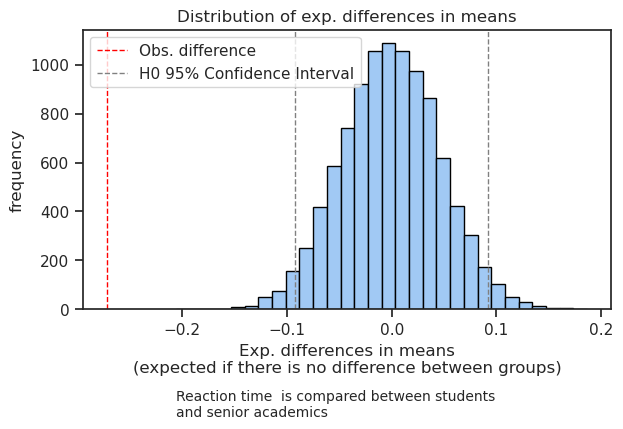

In [208]:
mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_bootstrap_analysis(rt_full, 'rt', type_col='group')
plot_bresults(mean_expected_diffs, delta, ci_mean, col='', text_add="Reaction time ")

paper_table.loc[len(paper_table)] = ['Reaction time', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , round(p_value_mean, 4), round(p_value_mean, 4), round(Crit_metric, 2), round(pst, 4), round(pst, 4)]

# p_value_mean, normal, pst = full_bootstrap_analysis(rt_full, 'rt', type_col='group')

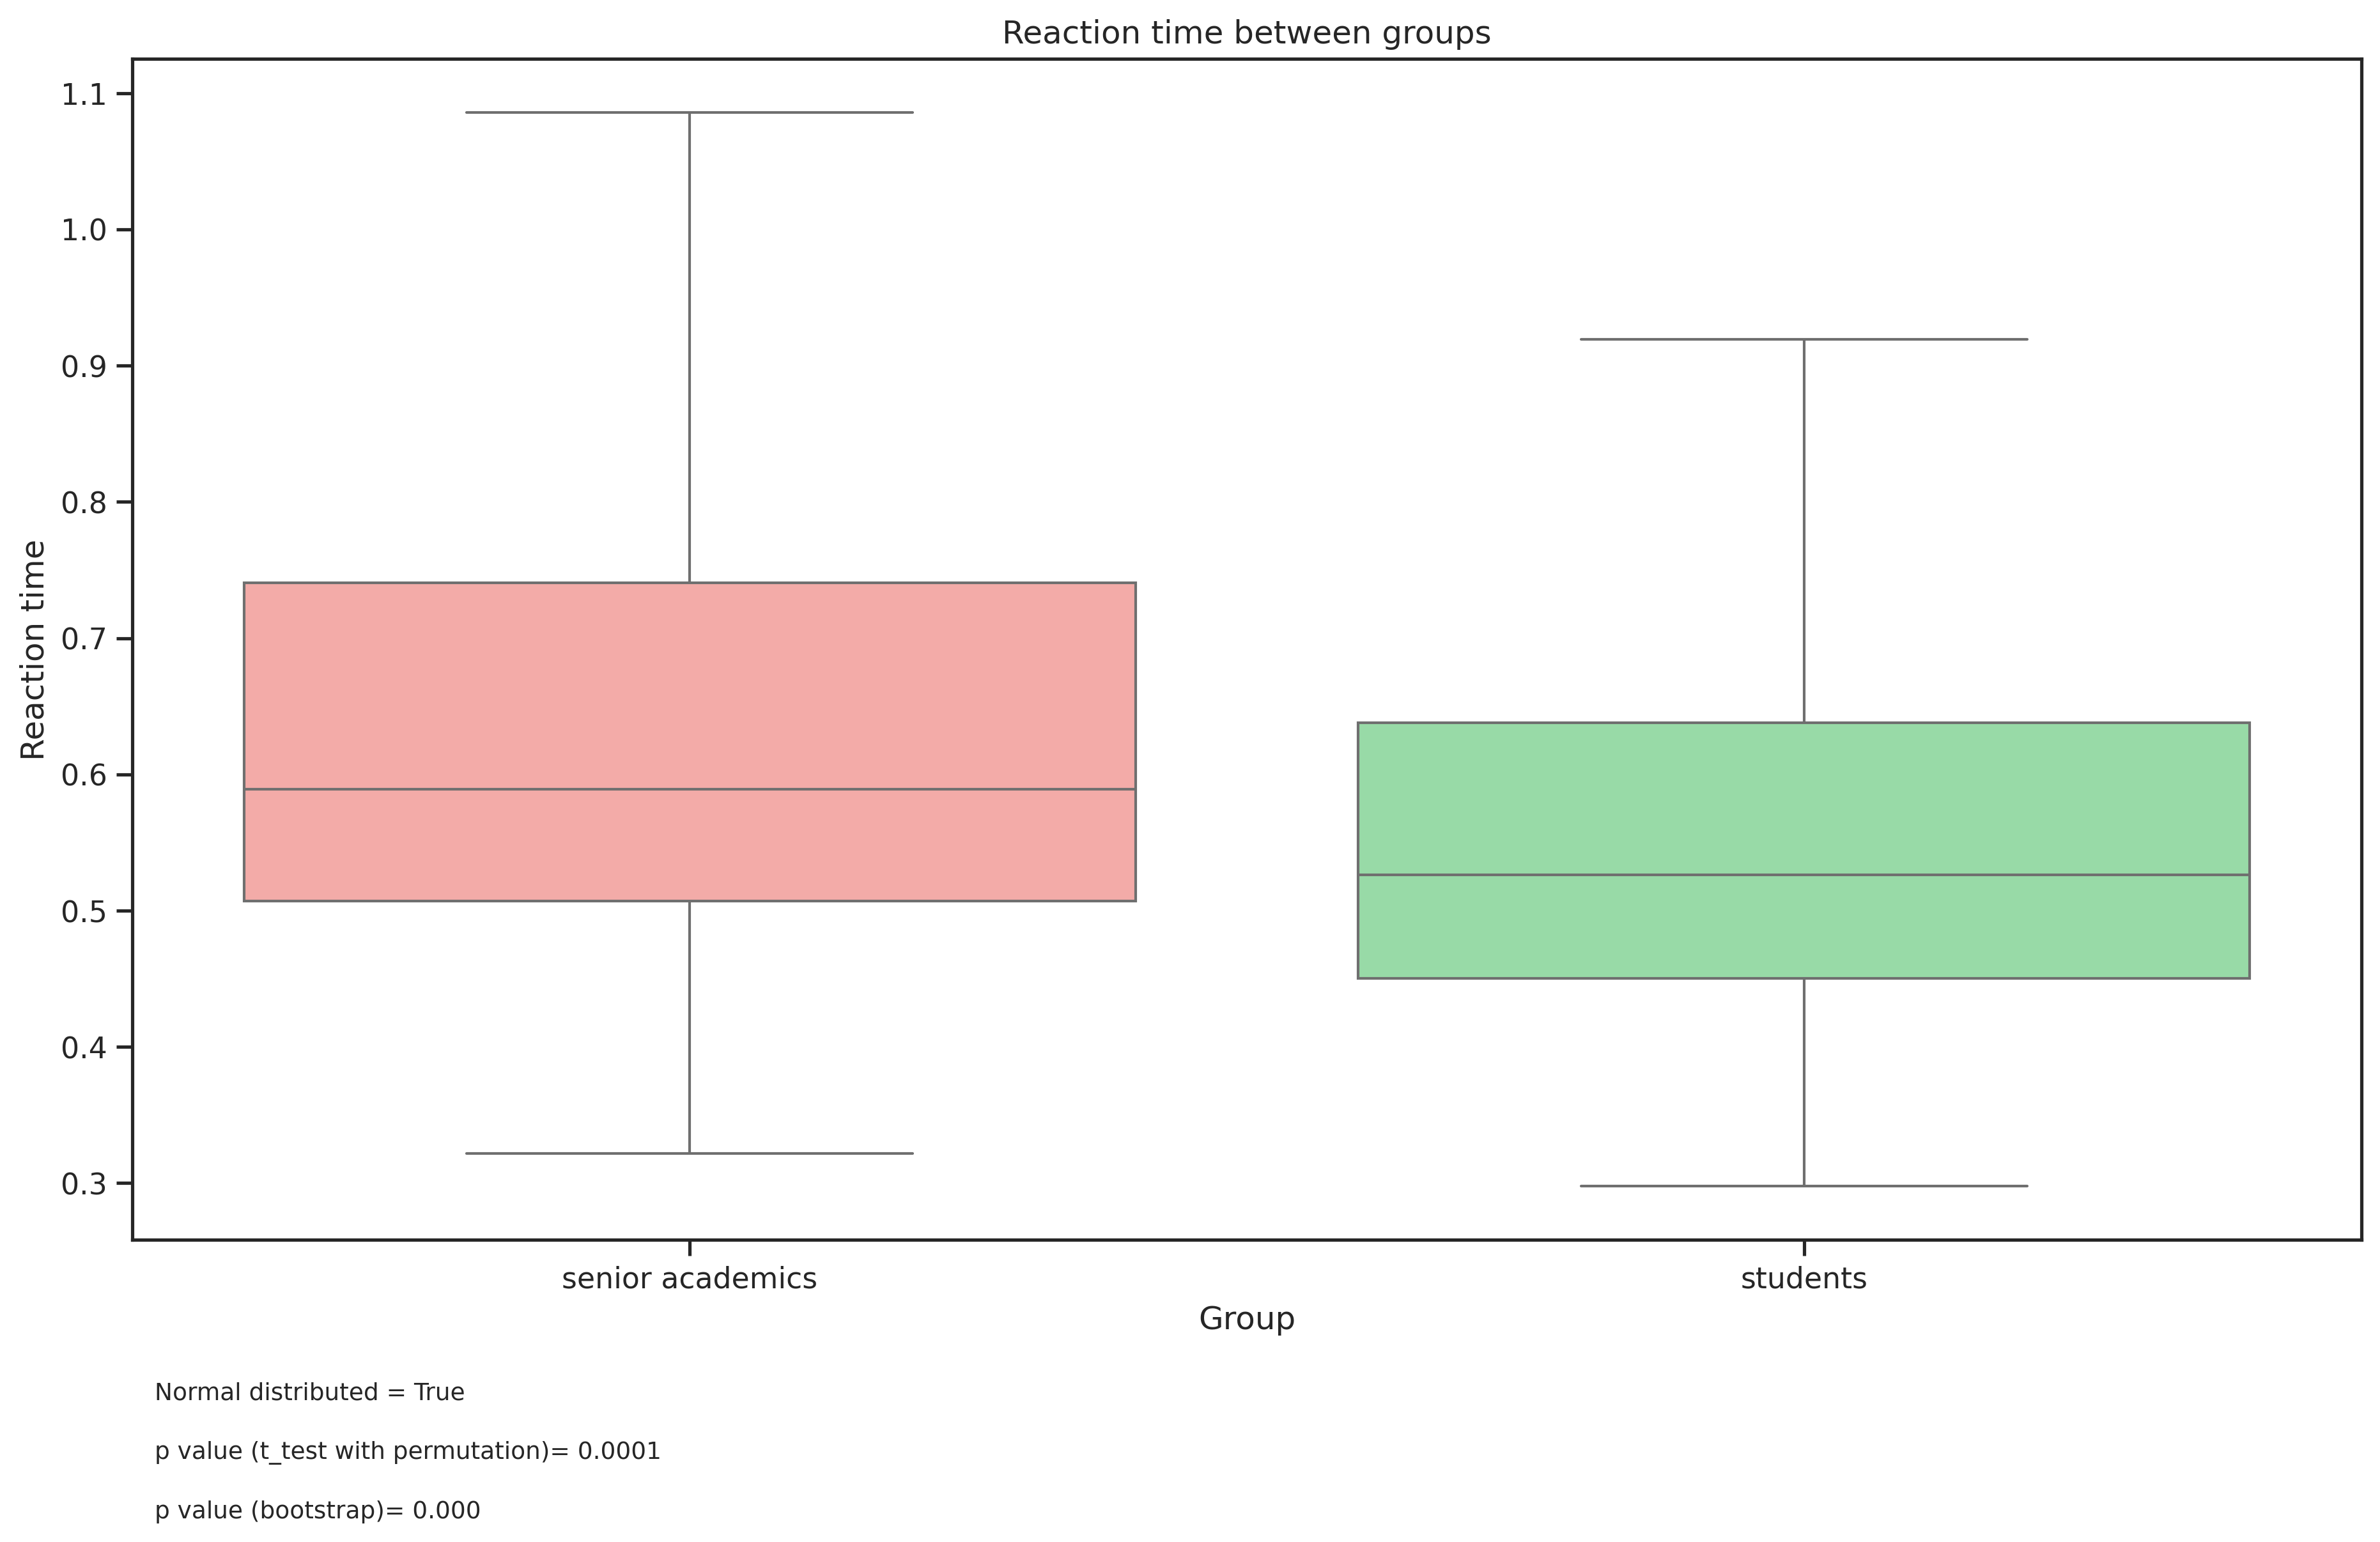

In [209]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(15, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt_full, y='rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
if 1:
      g.text(0.01
             , -0.17, f"p value (t_test with permutation)= {pst:.4f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
else:
      g.text(-0.25-0.05, -0.17, f"p value (M-U test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
g.text(0.01, -0.22, f"p value (bootstrap)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
plt.xlabel('Group')
plt.ylabel('Reaction time')
plt.title('Reaction time between groups')
fig.savefig(f'figures/Reaction time between groups.png', bbox_inches='tight')

In [90]:
# conf_interval = []
# pval = []
# es = []
# rt.columns = ['participant', 'mean_rt', 'type']

# # print(i)
# ci, p_value, observed_diff, mdelta_, cohens_d = full_bootstrap_mean_diff(rt, 'mean_rt')
# conf_interval.append(ci)
# pval.append(p_value)
# es.append(cohens_d)
# print('\n')

# RT correlation

In [210]:
# rt = pd.read_csv('results_academic_student.csv', sep=';')
# rt.head()

In [211]:
stuts = pd.read_csv('Список_студентов_психфак_мгу_весна_осень_24_2.csv', sep = '\t')
stuts['ID autumn'] = pd.to_numeric(stuts['ID autumn'], downcast='integer')
stuts['ID autumn']= stuts['ID autumn'].fillna(0).astype('int64')
stuts = stuts[['ID', 'ID autumn']]

In [212]:
academics = pd.read_excel('senior_academics_ids.xlsx')
academics['ID autumn'] = pd.to_numeric(academics['ID_new'], downcast='integer')
academics['ID autumn']= academics['ID autumn'].fillna(0).astype('int64')
# academics.head(1)
academics = academics[['ID', 'ID autumn']]

In [213]:
ids_ac_st = pd.concat([academics, stuts])
rt_ = rt.merge(ids_ac_st, left_on='participant', right_on='ID autumn', how='inner')

In [214]:
fullrt_ = rt_full.merge(ids_ac_st, left_on='participant', right_on='ID autumn', how='inner')

In [215]:
fullrt_.head(2)

,participant,accuracy,rt,group,rt_standardized,ID,ID autumn
0,12001,1,1.053446,senior academics,1.632106,pr_M_2,12001
1,12001,1,1.504920,senior academics,3.337005,pr_M_2,12001


In [216]:
rt_for_cor = dfjj[['ID', 'frequency', 'pause', 'mean pause', 'type',
       'strategy_paper_name', 'Word frequency', 'Pause duration', 'order_letter', 'order_whole_test']].merge(rt_, on='ID', how='inner')
fullrt_for_cor = dfjj[['ID', 'frequency', 'pause', 'mean pause', 'type',
       'strategy_paper_name', 'Word frequency', 'Pause duration', 'order_letter', 'order_whole_test']].merge(fullrt_, on='ID', how='inner')

In [217]:
rt_for_cor = rt_for_cor[['ID', 'mean pause', 'type', 'strategy_paper_name',
       'Word frequency', 'Pause duration', 'mean_rt', 'group',
       'mean_rt_standardized', 'order_letter', 'order_whole_test']]
fullrt_for_cor = fullrt_for_cor[['ID', 'mean pause', 'type', 'strategy_paper_name',
       'Word frequency', 'Pause duration', 'rt', 'group',
       'rt_standardized', 'order_letter', 'order_whole_test']]

In [218]:
fullrt_for_cor = fullrt_for_cor[['ID',
       'Pause duration', 'rt', 'group',
       'rt_standardized']].drop_duplicates()
fullrt_for_cor.head(2)

,ID,Pause duration,rt,group,rt_standardized
0,Б_В_24,1.63,0.610993,students,-0.038727
1,Б_В_24,1.63,0.521008,students,-0.378536


In [110]:
# sns.relplot(data=rt_for_cor, x='order_letter', y='Pause duration')
# sns.scatterplot(data=rt_for_cor, y='order_whole_test', x='Pause duration')
# sns.scatterplot(data=rt_for_cor, y='order_letter', x='Pause duration')

In [111]:
# rt[rt['mean_rt']>1]

In [112]:
# sns.histplot(rt['mean_rt'])

In [113]:
# rt_for_cor[~rt_for_cor['additional'].isna()]
# rt_for_cor = rt_for_cor[rt_for_cor['mean_rt']<=1]

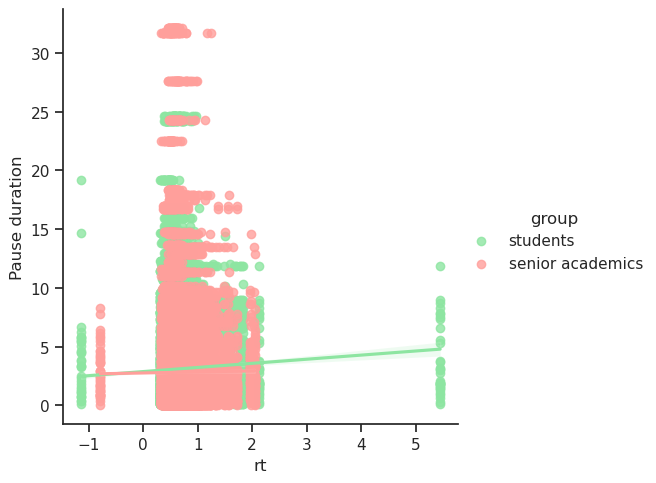

In [219]:
axs = sns.set_theme(style="ticks", palette="pastel");
axs = sns.lmplot(data=fullrt_for_cor, x='rt', y='Pause duration', hue='group', palette={'senior academics':'r', 'students':'g'});

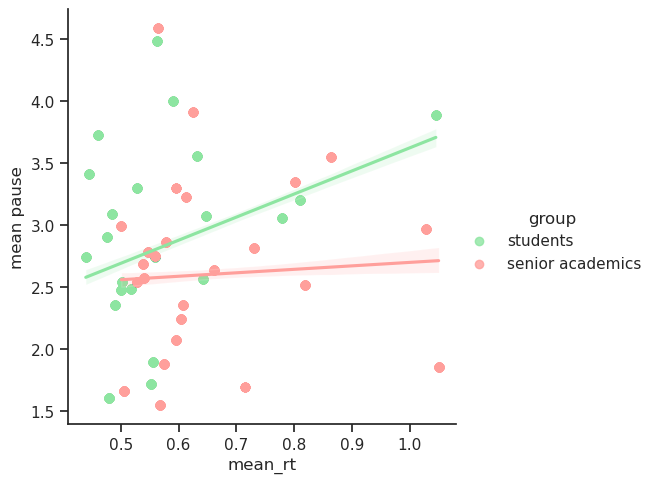

In [220]:
axs = sns.set_theme(style="ticks", palette="pastel");
axs = sns.lmplot(data=rt_for_cor, x='mean_rt', y='mean pause', hue='group', palette={'senior academics':'r', 'students':'g'});

In [221]:
fullrtcor = fullrt_for_cor.drop_duplicates()
x = fullrtcor['rt']
y = fullrtcor['Pause duration']
print(stats.pearsonr(x,y))    # Pearson's r

print(stats.spearmanr(x,y) )  # Spearman's rho

print(stats.kendalltau(x,y) ) # Kendall's tau

PearsonRResult(statistic=0.012007125431173587, pvalue=0.0012442010760048844)
SignificanceResult(statistic=0.03129580759233792, pvalue=3.870245915001865e-17)
SignificanceResult(statistic=0.02112494541446955, pvalue=1.801096179337337e-17)


In [222]:
rtcor = rt_for_cor[['mean pause', 'mean_rt', 'ID', 'group']].drop_duplicates()
x = rtcor['mean_rt']
y = rtcor['mean pause']
print(stats.pearsonr(x,y))    # Pearson's r

print(stats.spearmanr(x,y) )  # Spearman's rho

print(stats.kendalltau(x,y) ) # Kendall's tau

PearsonRResult(statistic=0.10710010725138666, pvalue=0.4736611353323659)
SignificanceResult(statistic=0.1502081406105458, pvalue=0.31356107137254163)
SignificanceResult(statistic=0.1082331174838113, pvalue=0.2832966676073182)


In [223]:
rtcor.groupby('group').count()

,mean pause,mean_rt,ID
group,,,
senior academics,25,25,25
students,22,22,22


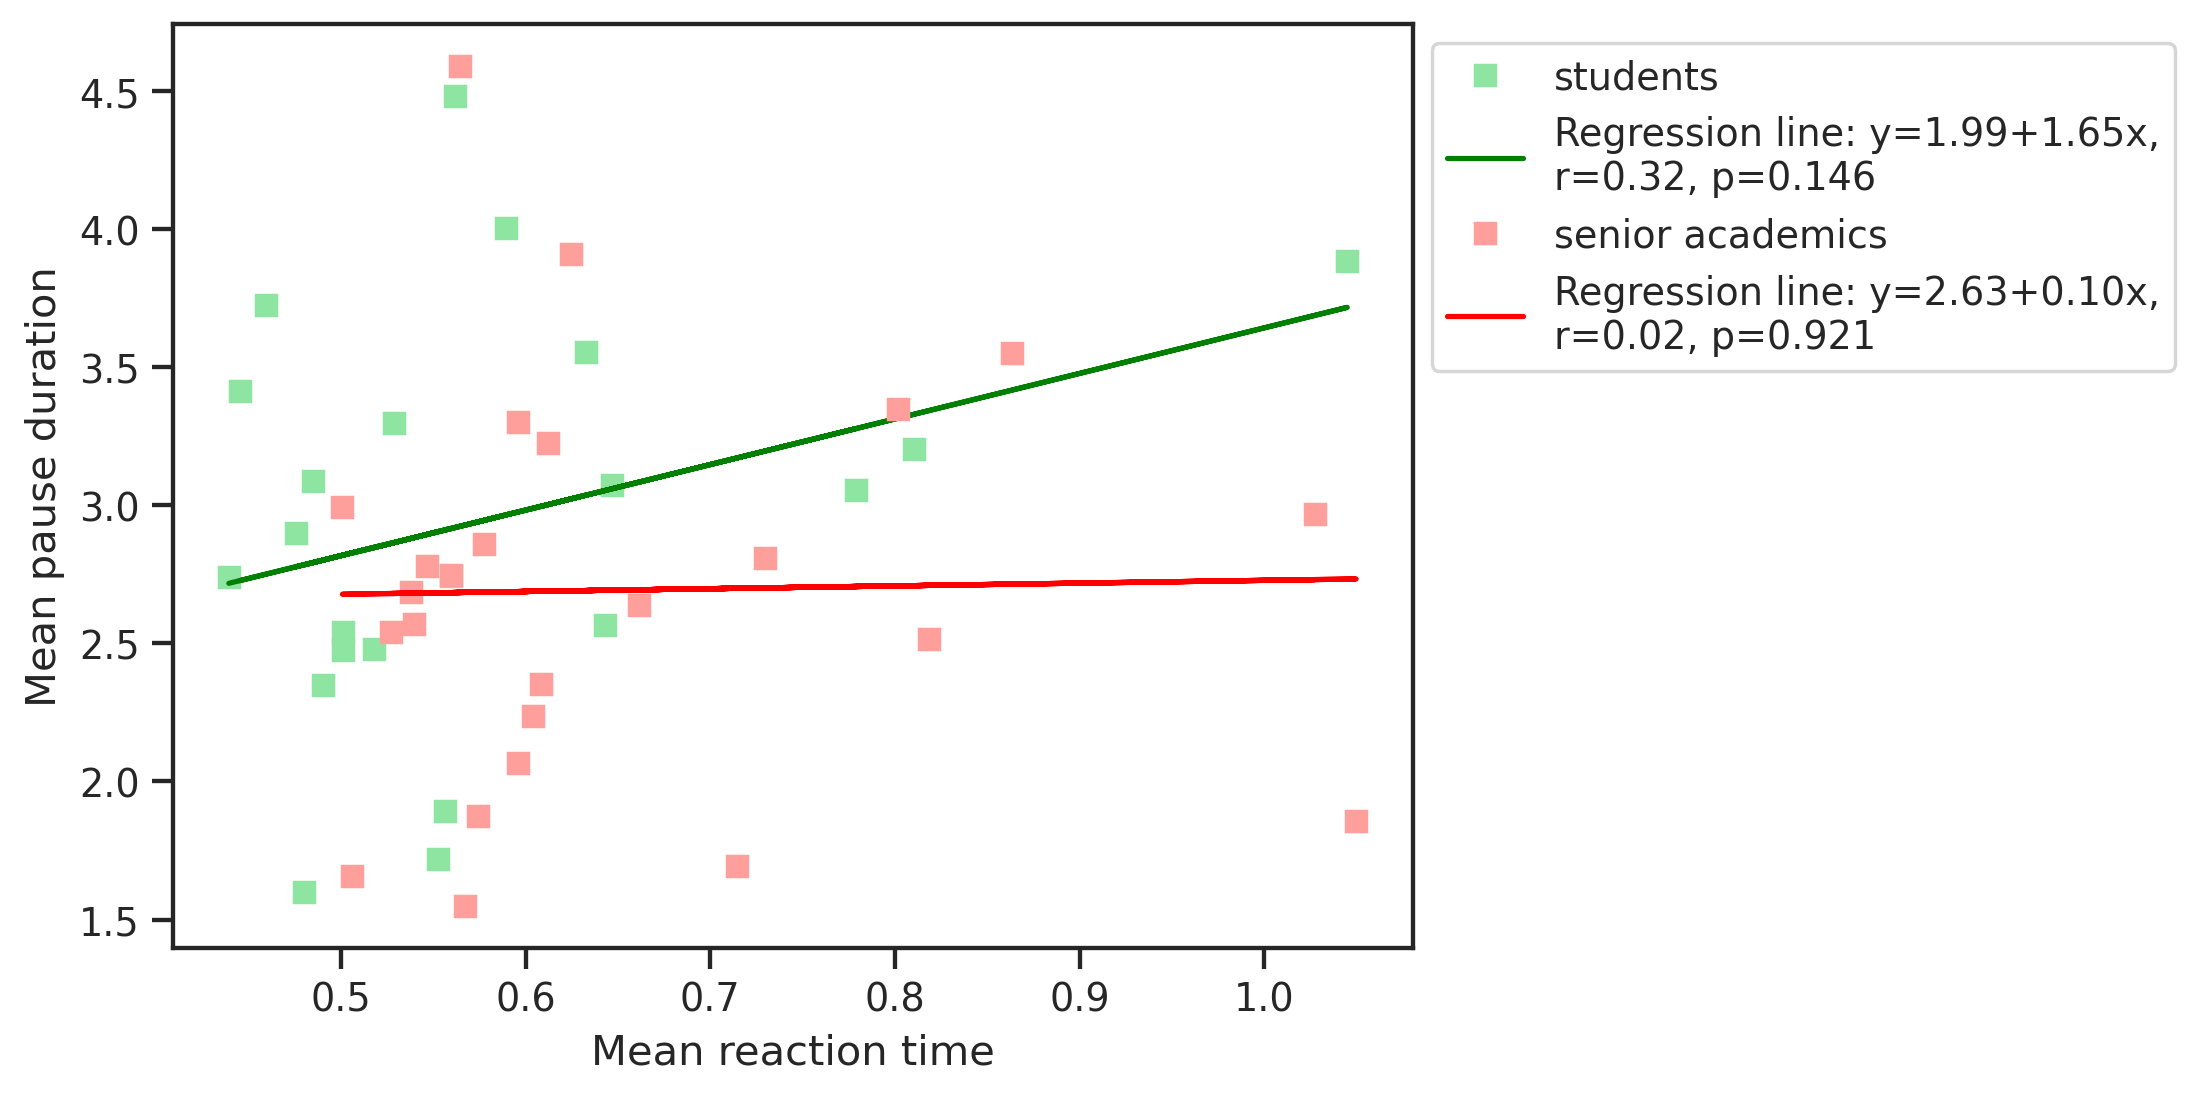

In [224]:
x1 = rtcor[rtcor['group']=='students']['mean_rt']
y1 = rtcor[rtcor['group']=='students']['mean pause']
x2 = rtcor[rtcor['group']!='students']['mean_rt']
y2 = rtcor[rtcor['group']!='students']['mean pause']

slope, intercept, r, p, stderr = stats.linregress(x1, y1)
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
fig, ax = plt.subplots(dpi=250)
# ax.set_color_cycle(['green', 'red'])
ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
ax.plot(x1, intercept + slope * x1, label=line, color='green')

slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

ax.set_xlabel('Mean reaction time')
ax.set_ylabel('Mean pause duration')
ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# plt.tight_layout()

# ax.legend(facecolor='white')
plt.show()
fig.savefig(f'figures/Mean reaction time ~ Mean pause duration.png', bbox_inches='tight')

In [63]:
# x1 = rtcor[rtcor['group']=='students']['mean_rt']
# y1 = rtcor[rtcor['group']=='students']['mean pause']
# x2 = rtcor[rtcor['group']!='students']['mean_rt']
# y2 = rtcor[rtcor['group']!='students']['mean pause']

# slope, intercept, r, p, stderr = stats.linregress(x1, y1)
# line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
# fig, ax = plt.subplots(dpi=250)
# # ax.set_color_cycle(['green', 'red'])
# ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
# ax.plot(x1, intercept + slope * x1, label=line, color='green')

# slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
# line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
# ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
# ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

# ax.set_xlabel('Mean reaction time')
# ax.set_ylabel('Mean pause duration')
# ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# # plt.tight_layout()

# # ax.legend(facecolor='white')
# plt.show()
# fig.savefig(f'figures/Mean reaction time ~ Mean pause duration.png', bbox_inches='tight')

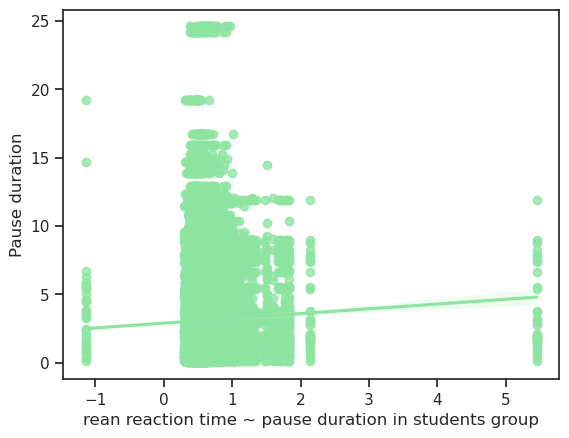

In [119]:
# fig, axs = plt.subplots(figsize=(8, 8), dpi=150)
# plt.figure(figsize=(10, 6))
    
# fig, axs = plt.subplots(figsize=(7, 7), dpi=120)

sns.regplot(data=fullrt_for_cor[fullrt_for_cor['group']=='students'], x='rt', y='Pause duration', color='g')
plt.xlabel('rean reaction time ~ pause duration in students group');

In [306]:
# sns.scatterplot(data=rt_for_cor, x='mean_rt', y='mean pause')

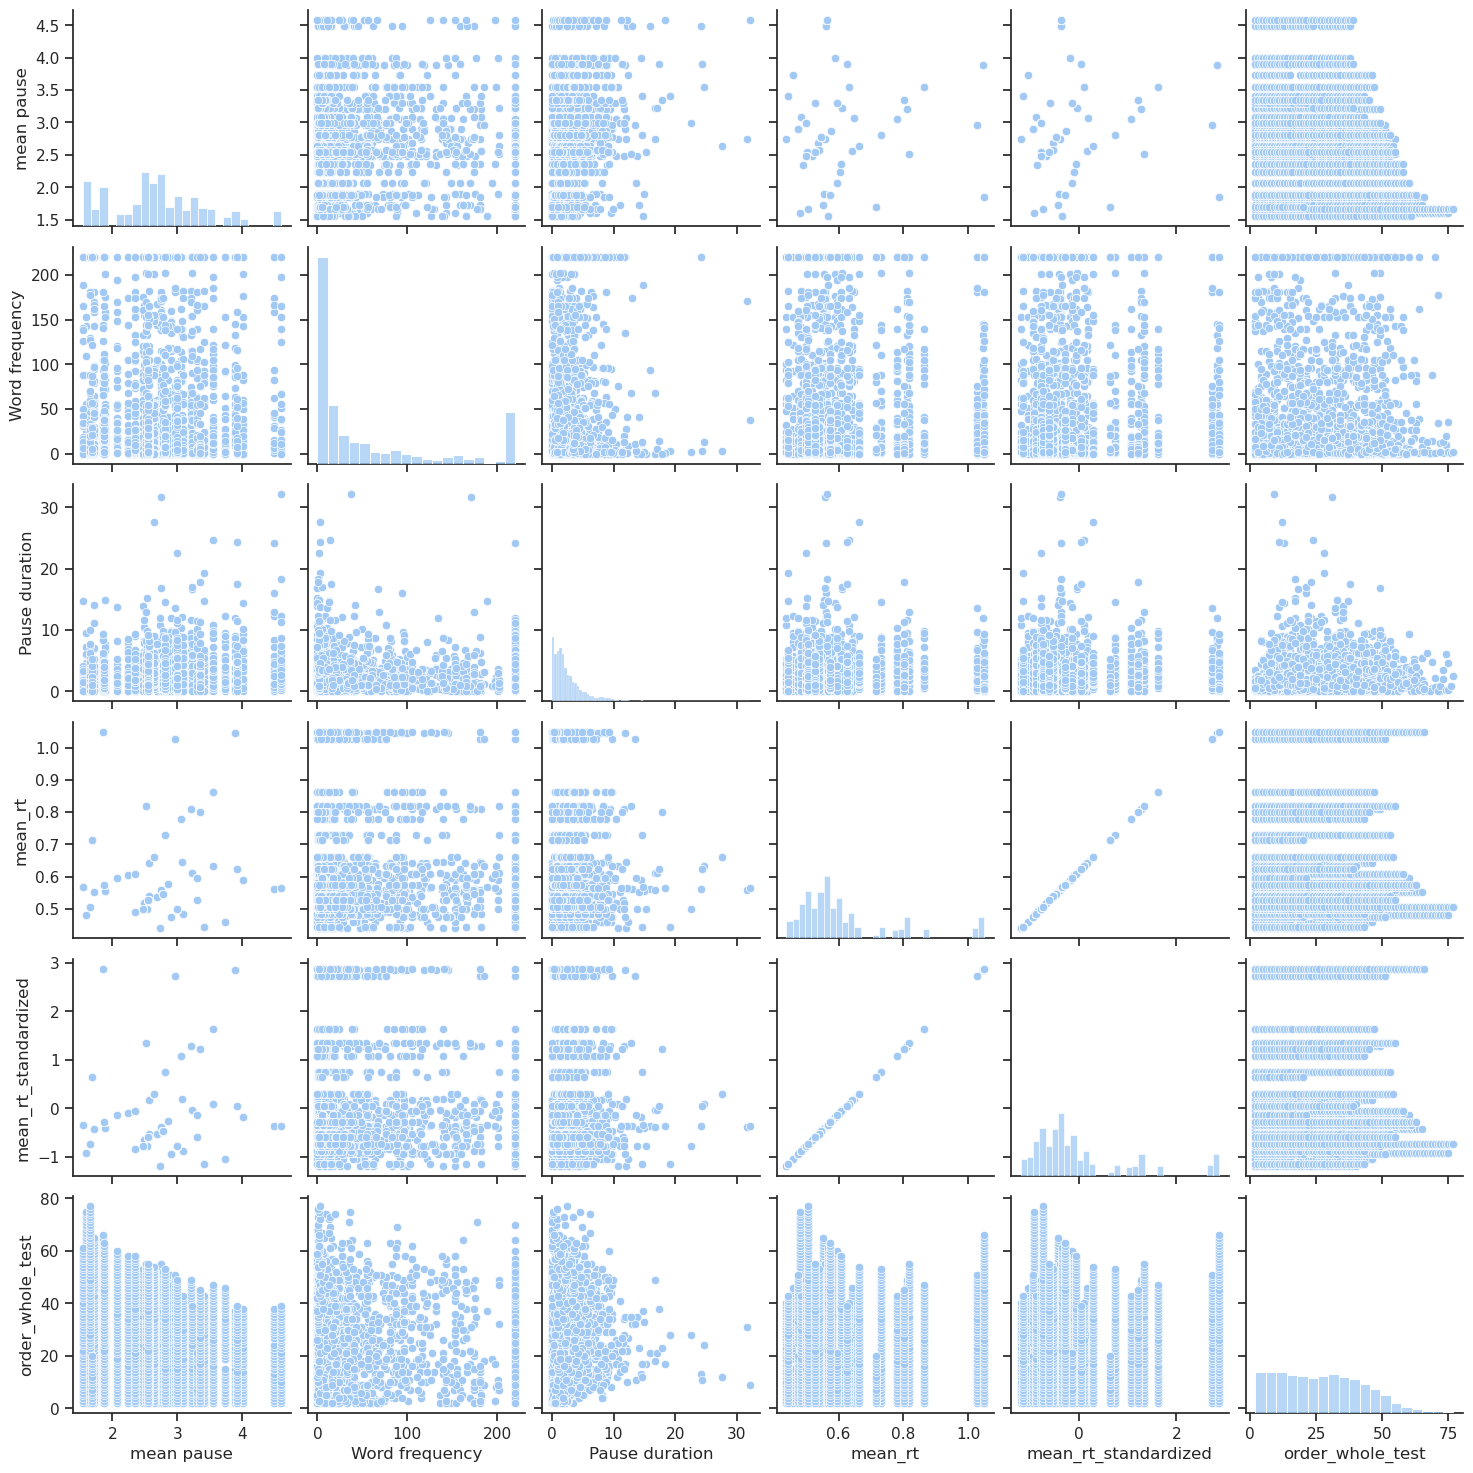

In [120]:
# fig, ax = plt.subplots(dpi=300)
ax = sns.pairplot(rt_for_cor[['mean pause', 
       'Word frequency', 'Pause duration', 'mean_rt', 
       'mean_rt_standardized', 'order_letter', 'order_whole_test']]);
ax.savefig(f'figures/pairplot.png', bbox_inches='tight')

In [304]:
# sns.lineplot(data=rt_for_cor, y='order_letter', x='Pause duration')

In [305]:
# sns.lineplot(data=rt_for_cor, x='mean_rt', y='Pause duration')
# sns.lineplot(data=rt_for_cor, x='mean_rt', y='mean pause')

# Result table fix

## 1

In [227]:
paper_table = paper_table.drop_duplicates(subset=['Variable'], keep='last')

In [228]:
strategies_dict

{'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy': 'S3',
 'individual association strategy': 'S4'}

In [229]:
final_paper_table = paper_table.copy()

In [230]:
final_paper_table['Variable'] = (paper_table['Variable'].str.replace('phonetic strategy', 'S1')
 .str.replace('derivative strategy', 'S2')
 .str.replace('semantic-field strategy', 'S3')
 .str.replace('individual association strategy', 'S4')
)

In [231]:
final_paper_table['Statistical test']=(final_paper_table['Normal sampling distribution']
                                       .apply(lambda x: 'Two-Sample two-tailed t-Test' if x else 'Mann–Whitney U test'))

In [233]:
round(0.616638, 4)

0.6166

In [235]:
final_paper_table['Bootstrap p value corrected'] = final_paper_table['Bootstrap p value corrected'].apply(lambda x:round(x, 4))
final_paper_table['Stat p value corrected'] = final_paper_table['Stat p value corrected'].apply(lambda x:round(x, 4))

In [236]:
final_paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Bootstrap p value,Bootstrap p value corrected,Stat metric value,Stat p value,Stat p value corrected,Statistical test
0,Fraction of S1,True,"[-0.54, 0.53]",-0.73,-0.76,0.0079,0.0105,-2.75,0.0080,0.0107,Two-Sample two-tailed t-Test
1,Fraction of S2,True,"[-0.54, 0.54]",0.15,0.15,0.5867,0.5867,0.53,0.6166,0.6166,Two-Sample two-tailed t-Test
2,Fraction of S3,True,"[-0.56, 0.54]",-0.82,-0.88,0.0033,0.0066,-3.15,0.0035,0.0070,Two-Sample two-tailed t-Test
3,Fraction of S4,True,"[-0.53, 0.52]",0.90,0.97,0.0014,0.0056,3.52,0.0008,0.0032,Two-Sample two-tailed t-Test
12,Pause duration of S1,False,"[-0.25, 0.27]",-0.26,-0.26,0.0485,0.0970,5766.50,0.0111,0.0222,Mann–Whitney U test
13,Pause duration of S2,True,"[-0.29, 0.29]",0.38,0.38,0.0104,0.0416,2.61,0.0059,0.0222,Two-Sample two-tailed t-Test
14,Pause duration of S3,True,"[-0.18, 0.18]",-0.04,-0.04,0.6808,0.6808,-0.42,0.6750,0.9000,Two-Sample two-tailed t-Test
15,Pause duration of S4,False,"[-0.1, 0.1]",0.04,0.04,0.4203,0.5604,273376.50,0.9552,0.9552,Mann–Whitney U test
16,Word frequency of S1,True,"[-0.25, 0.26]",0.06,0.06,0.6496,0.6496,0.45,0.6574,0.6574,Two-Sample two-tailed t-Test
17,Word frequency of S2,True,"[-0.29, 0.29]",0.29,0.29,0.0465,0.0930,1.99,0.0489,0.0978,Two-Sample two-tailed t-Test


In [237]:
final_paper_table.to_csv('results/paper_table.csv', index=False, sep=';')

In [240]:
# final_paper_table.to_excel('results/paper_table.xlsx', index=False)

## 2

In [241]:
# final_paper_table = pd.read_excel('results/paper_table.xlsx')
final_paper_table = pd.read_csv('results/paper_table.csv', sep=';')
final_paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Bootstrap p value,Bootstrap p value corrected,Stat metric value,Stat p value,Stat p value corrected,Statistical test
0,Fraction of S1,True,"[-0.54, 0.53]",-0.73,-0.76,0.0079,0.0105,-2.75,0.0080,0.0107,Two-Sample two-tailed t-Test
1,Fraction of S2,True,"[-0.54, 0.54]",0.15,0.15,0.5867,0.5867,0.53,0.6166,0.6166,Two-Sample two-tailed t-Test
2,Fraction of S3,True,"[-0.56, 0.54]",-0.82,-0.88,0.0033,0.0066,-3.15,0.0035,0.0070,Two-Sample two-tailed t-Test
3,Fraction of S4,True,"[-0.53, 0.52]",0.90,0.97,0.0014,0.0056,3.52,0.0008,0.0032,Two-Sample two-tailed t-Test
4,Pause duration of S1,False,"[-0.25, 0.27]",-0.26,-0.26,0.0485,0.0970,5766.50,0.0111,0.0222,Mann–Whitney U test
5,Pause duration of S2,True,"[-0.29, 0.29]",0.38,0.38,0.0104,0.0416,2.61,0.0059,0.0222,Two-Sample two-tailed t-Test
6,Pause duration of S3,True,"[-0.18, 0.18]",-0.04,-0.04,0.6808,0.6808,-0.42,0.6750,0.9000,Two-Sample two-tailed t-Test
7,Pause duration of S4,False,"[-0.1, 0.1]",0.04,0.04,0.4203,0.5604,273376.50,0.9552,0.9552,Mann–Whitney U test
8,Word frequency of S1,True,"[-0.25, 0.26]",0.06,0.06,0.6496,0.6496,0.45,0.6574,0.6574,Two-Sample two-tailed t-Test
9,Word frequency of S2,True,"[-0.29, 0.29]",0.29,0.29,0.0465,0.0930,1.99,0.0489,0.0978,Two-Sample two-tailed t-Test
